# File to generate Prediction models for each station
**uses models generated in RandomForestWeather to generate future weather parameters**
**Weather paraemeters joined with datetime parameters are used for prediction of** 
 - available_bike_stands
 - available_bikes

## Data Preparation

In [1]:
# Import pandas, numpy, matplotlib, seaborn libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tabulate import tabulate
import datetime

# Using sklearn to split data into training and testing sets,train classifier and regressor models 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

#pickle package saves and loads sklearn models
import pickle

# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Import data

### Import bike dynamic data from csv into dataframe

In [2]:
# Read in data as pandas dataframe and display first 5 rows
bikeDynamic = pd.read_csv('dBikeD.csv')
bikeDynamic = bikeDynamic.drop(columns=['last_update', 'status'])
bikeDynamic.tail(5)

id_Entry  number  bike_stands  available_bike_stands  available_bikes  \
369165    370900      39           20                      6               14   
369166    370901      83           40                     27               13   
369167    370902      92           40                     25               15   
369168    370903      21           30                     22                8   
369169    370904      88           30                      9               21   

       data_entry_timestamp  
369165      8/24/2020 10:40  
369166      9/24/2020 10:50  
369167      10/24/2020 0:00  
369168     11/24/2020 11:10  
369169     12/24/2020 11:20

#### check for shape

In [3]:
print('The shape of our features is:', bikeDynamic.shape,'\n', bikeDynamic.dtypes)

The shape of our features is: (369170, 6) 
 id_Entry                  int64
number                    int64
bike_stands               int64
available_bike_stands     int64
available_bikes           int64
data_entry_timestamp     object
dtype: object


#### check for Null entries

In [4]:
bikeDynamic.isnull().sum()

id_Entry                 0
number                   0
bike_stands              0
available_bike_stands    0
available_bikes          0
data_entry_timestamp     0
dtype: int64

### Import weather dynamic data from csv into dataframe

In [5]:
# Read in data as pandas dataframe and display first 5 rows
weatherDynamic = pd.read_csv('dWeatherD.csv')
bikeDynamic.reset_index(drop=True)
weatherDynamic = weatherDynamic[['main_temp','main_feels_like', 'main_pressure', 'main_humidity', \
                 'main_temp_min', 'main_temp_max', 'wind_speed', 'wind_deg', 'data_entry_timestamp']]
weatherDynamic.tail(5)

main_temp  main_feels_like  main_pressure  main_humidity  main_temp_min  \
3437         10                7           1018             66              8   
3438         11                9           1017             58              9   
3439         11                9           1017             58              9   
3440         11                9           1017             58              9   
3441         11                7           1017             62             10   

      main_temp_max  wind_speed  wind_deg data_entry_timestamp  
3437             12         2.6     150.0      8/24/2020 10:40  
3438             12         1.0       NaN      9/24/2020 10:50  
3439             12         1.0       NaN      10/24/2020 0:00  
3440             12         1.0       NaN     11/24/2020 11:10  
3441             12         4.1     200.0     12/24/2020 11:20

#### check for shape

In [6]:
print('The shape of our features is:', weatherDynamic.shape,'\n', weatherDynamic.dtypes)

The shape of our features is: (3442, 9) 
 main_temp                 int64
main_feels_like           int64
main_pressure             int64
main_humidity             int64
main_temp_min             int64
main_temp_max             int64
wind_speed              float64
wind_deg                float64
data_entry_timestamp     object
dtype: object


#### check for Null entries

In [7]:
weatherDynamic.isnull().sum()

main_temp                 0
main_feels_like           0
main_pressure             0
main_humidity             0
main_temp_min             0
main_temp_max             0
wind_speed                0
wind_deg                112
data_entry_timestamp      0
dtype: int64

#### check for Null entries

In [8]:
weatherDynamic.loc[weatherDynamic['wind_deg'].isnull(),('wind_deg')] = weatherDynamic['wind_deg'].ffill()

In [9]:
weatherDynamic.isnull().sum()

main_temp               0
main_feels_like         0
main_pressure           0
main_humidity           0
main_temp_min           0
main_temp_max           0
wind_speed              0
wind_deg                0
data_entry_timestamp    0
dtype: int64

## Process and normalise dates

**Observation state that results for date 28 February and 24 March are patial. Hence, they can be dropped for data consistency. Its upto discration of user whether to incorporate it for training or not.** 

### dublin bikes
    


In [10]:
#DATETIME DATA

# Select columns containing datetime data
continous_date_columns = bikeDynamic[['data_entry_timestamp']].columns

# Assign object type datetime to columns enlisted in continous_date_columns
for column in continous_date_columns:
    bikeDynamic[column] = pd.to_datetime(bikeDynamic[column])  
    
# end_date = pd.to_datetime('2020-03-24')
# start_date = pd.to_datetime('2020-02-28')

# # Ommit partial data for dates 28-2-2020 and 24-3-2020
# mask = (bikeDynamic['data_entry_timestamp'].dt.date > start_date) & (bikeDynamic['data_entry_timestamp'].dt.date < end_date)
# bikeDynamic = bikeDynamic.loc[mask]

# # resolution to minutes
bikeDynamic['data_entry_timestamp'] = bikeDynamic['data_entry_timestamp'].dt.strftime("%Y-%m-%d %H:%M:00")

for column in continous_date_columns:
    bikeDynamic[column] = pd.to_datetime(bikeDynamic[column]) 
    
bikeDynamic.tail()

id_Entry  number  bike_stands  available_bike_stands  available_bikes  \
369165    370900      39           20                      6               14   
369166    370901      83           40                     27               13   
369167    370902      92           40                     25               15   
369168    370903      21           30                     22                8   
369169    370904      88           30                      9               21   

       data_entry_timestamp  
369165  2020-08-24 10:40:00  
369166  2020-09-24 10:50:00  
369167  2020-10-24 00:00:00  
369168  2020-11-24 11:10:00  
369169  2020-12-24 11:20:00

In [11]:
print('The shape of our features is:', bikeDynamic.shape,'\n', bikeDynamic.dtypes)

The shape of our features is: (369170, 6) 
 id_Entry                          int64
number                            int64
bike_stands                       int64
available_bike_stands             int64
available_bikes                   int64
data_entry_timestamp     datetime64[ns]
dtype: object


### dublin weather

In [12]:
#DATETIME DATA

# Select columns containing datetime data
continous_date_columns = weatherDynamic[['data_entry_timestamp']].columns

# Assign object type datetime to columns enlisted in continous_date_columns
for column in continous_date_columns:
    weatherDynamic[column] = pd.to_datetime(weatherDynamic[column])   
    
# end_date = pd.to_datetime('2020-03-24')
# start_date = pd.to_datetime('2020-02-28')

# # Ommit partial data for dates 28-2-2020 and 24-3-2020
# mask = (weatherDynamic['data_entry_timestamp'].dt.date > start_date) & (weatherDynamic['data_entry_timestamp'].dt.date < end_date)
# weatherDynamic = weatherDynamic.loc[mask]

# for column in continous_date_columns:
#     weatherDynamic[column] = pd.to_datetime(weatherDynamic[column])   
    
weatherDynamic.tail()

main_temp  main_feels_like  main_pressure  main_humidity  main_temp_min  \
3437         10                7           1018             66              8   
3438         11                9           1017             58              9   
3439         11                9           1017             58              9   
3440         11                9           1017             58              9   
3441         11                7           1017             62             10   

      main_temp_max  wind_speed  wind_deg data_entry_timestamp  
3437             12         2.6     150.0  2020-08-24 10:40:00  
3438             12         1.0     150.0  2020-09-24 10:50:00  
3439             12         1.0     150.0  2020-10-24 00:00:00  
3440             12         1.0     150.0  2020-11-24 11:10:00  
3441             12         4.1     200.0  2020-12-24 11:20:00

In [13]:
print('The shape of our features is:', weatherDynamic.shape,'\n', weatherDynamic.dtypes)

The shape of our features is: (3442, 9) 
 main_temp                        int64
main_feels_like                  int64
main_pressure                    int64
main_humidity                    int64
main_temp_min                    int64
main_temp_max                    int64
wind_speed                     float64
wind_deg                       float64
data_entry_timestamp    datetime64[ns]
dtype: object


### Merge bike and weather dataframes

In [14]:
bikeDynamic.head()

id_Entry  number  bike_stands  available_bike_stands  available_bikes  \
0      1745      42           30                     17               13   
1      1746      30           20                     16                4   
2      1747      54           33                     22                9   
3      1748     108           40                     37                3   
4      1749      56           40                     13               27   

  data_entry_timestamp  
0  2020-02-28 15:00:00  
1  2020-02-28 15:00:00  
2  2020-02-28 15:00:00  
3  2020-02-28 15:00:00  
4  2020-02-28 15:00:00

In [15]:
weatherDynamic.head()

main_temp  main_feels_like  main_pressure  main_humidity  main_temp_min  \
0         12                7            987             87             11   
1         12                7            987             87             11   
2         11                6            987             87             11   
3         12                5            987             71             11   
4         12                5            987             71             11   

   main_temp_max  wind_speed  wind_deg data_entry_timestamp  
0             14         7.2     250.0  2020-02-28 15:00:00  
1             14         7.2     250.0  2020-02-28 15:10:00  
2             12         7.2     250.0  2020-02-28 15:20:00  
3             12         8.2     250.0  2020-02-28 15:30:00  
4             12         8.2     250.0  2020-02-28 15:40:00

In [16]:
dfML = pd.merge(bikeDynamic, weatherDynamic, on='data_entry_timestamp')
print(dfML.shape)
dfML.head()

(369170, 14)


id_Entry  number  bike_stands  available_bike_stands  available_bikes  \
0      1745      42           30                     17               13   
1      1746      30           20                     16                4   
2      1747      54           33                     22                9   
3      1748     108           40                     37                3   
4      1749      56           40                     13               27   

  data_entry_timestamp  main_temp  main_feels_like  main_pressure  \
0  2020-02-28 15:00:00         12                7            987   
1  2020-02-28 15:00:00         12                7            987   
2  2020-02-28 15:00:00         12                7            987   
3  2020-02-28 15:00:00         12                7            987   
4  2020-02-28 15:00:00         12                7            987   

   main_humidity  main_temp_min  main_temp_max  wind_speed  wind_deg  
0             87             11             14         7.2     250.0  
1             87             11             14         7.2     250.0  
2             87             11             14         7.2     250.0  
3             87             11             14         7.2     250.0  
4             87             11             14         7.2     250.0

In [17]:
print('The shape of our features is:', dfML.shape,'\n', dfML.dtypes)

The shape of our features is: (369170, 14) 
 id_Entry                          int64
number                            int64
bike_stands                       int64
available_bike_stands             int64
available_bikes                   int64
data_entry_timestamp     datetime64[ns]
main_temp                         int64
main_feels_like                   int64
main_pressure                     int64
main_humidity                     int64
main_temp_min                     int64
main_temp_max                     int64
wind_speed                      float64
wind_deg                        float64
dtype: object


### Resolve date into time components

In [18]:
#Drop 'last_update' feature
dfML['year'] = dfML.data_entry_timestamp.dt.year 
dfML['Day'] = dfML.data_entry_timestamp.dt.day
dfML['month'] = dfML.data_entry_timestamp.dt.month
dfML['hour'] = dfML.data_entry_timestamp.dt.hour
dfML['minute'] = dfML.data_entry_timestamp.dt.minute
dfML['dayOfWeek'] = dfML.data_entry_timestamp.dt.weekday

### Check logical integrity of data 

**Data integrity is checked for following cases:**
 - is "bike_stands" $>=$ "available_bike_stands" $+$ "available_bikes"  [Any other sequence is incorrect]
 - is "last_update" $<=$ "data_entry_timestamp" [Any other sequence is incorrect]

In [19]:
test_1 = dfML[["id_Entry","available_bike_stands","available_bikes","bike_stands"]][dfML["available_bike_stands"].add(dfML["available_bikes"], axis=0)  >\
                                                                         dfML["bike_stands"]]
print("Number of rows failing the test: ", test_1.shape[0])
test_1.head(5)

Number of rows failing the test:  18


id_Entry  available_bike_stands  available_bikes  bike_stands
63885      65630                     17                0           16
248795    250540                     16                1           16
248905    250650                     16                1           16
249125    250870                     16                1           16
249235    250980                     16                1           16

#### Remove errors by adding available_bikes and bike_stands

In [20]:
dTest_1 = test_1["id_Entry"]

for data in dTest_1: 
    dfML.loc[(dfML.id_Entry == data),'bike_stands'] = dfML.loc[(dfML.id_Entry == data),'available_bikes'] + dfML.loc[(dfML.id_Entry == data),'available_bike_stands']

In [21]:
test_1 = dfML[["id_Entry","available_bike_stands","available_bikes","bike_stands"]][dfML["available_bike_stands"].add(dfML["available_bikes"], axis=0)  >\
                                                                         dfML["bike_stands"]]
print("Number of rows failing the test: ", test_1.shape[0])
test_1.head(5)

Number of rows failing the test:  0


Empty DataFrame
Columns: [id_Entry, available_bike_stands, available_bikes, bike_stands]
Index: []

### Set Data types prior to encoding

In [22]:
dfML = dfML.drop(['bike_stands','id_Entry', 'data_entry_timestamp'], axis = 1)
dfML.reset_index(drop = True)

number  available_bike_stands  available_bikes  main_temp  \
0           42                     17               13         12   
1           30                     16                4         12   
2           54                     22                9         12   
3          108                     37                3         12   
4           56                     13               27         12   
...        ...                    ...              ...        ...   
369165      39                      6               14         10   
369166      83                     27               13         11   
369167      92                     25               15         11   
369168      21                     22                8         11   
369169      88                      9               21         11   

        main_feels_like  main_pressure  main_humidity  main_temp_min  \
0                     7            987             87             11   
1                     7            987             87             11   
2                     7            987             87             11   
3                     7            987             87             11   
4                     7            987             87             11   
...                 ...            ...            ...            ...   
369165                7           1018             66              8   
369166                9           1017             58              9   
369167                9           1017             58              9   
369168                9           1017             58              9   
369169                7           1017             62             10   

        main_temp_max  wind_speed  wind_deg  year  Day  month  hour  minute  \
0                  14         7.2     250.0  2020   28      2    15       0   
1                  14         7.2     250.0  2020   28      2    15       0   
2                  14         7.2     250.0  2020   28      2    15       0   
3                  14         7.2     250.0  2020   28      2    15       0   
4                  14         7.2     250.0  2020   28      2    15       0   
...               ...         ...       ...   ...  ...    ...   ...     ...   
369165             12         2.6     150.0  2020   24      8    10      40   
369166             12         1.0     150.0  2020   24      9    10      50   
369167             12         1.0     150.0  2020   24     10     0       0   
369168             12         1.0     150.0  2020   24     11    11      10   
369169             12         4.1     200.0  2020   24     12    11      20   

        dayOfWeek  
0               4  
1               4  
2               4  
3               4  
4               4  
...           ...  
369165          0  
369166          3  
369167          5  
369168          1  
369169          3  

[369170 rows x 17 columns]

In [23]:
print('The shape of our features is:', dfML.shape,'\n', dfML.dtypes)

The shape of our features is: (369170, 17) 
 number                     int64
available_bike_stands      int64
available_bikes            int64
main_temp                  int64
main_feels_like            int64
main_pressure              int64
main_humidity              int64
main_temp_min              int64
main_temp_max              int64
wind_speed               float64
wind_deg                 float64
year                       int64
Day                        int64
month                      int64
hour                       int64
minute                     int64
dayOfWeek                  int64
dtype: object


In [24]:
# Assign data type category to columns listed in categorical_columns
categorical_columns = dfML[['year', 'month', 'dayOfWeek']].columns
for column in categorical_columns:
    dfML[column] = dfML[column].astype('category') 

In [25]:
print('The shape of our features is:', dfML.shape)
print(dfML.dtypes)

The shape of our features is: (369170, 17)
number                      int64
available_bike_stands       int64
available_bikes             int64
main_temp                   int64
main_feels_like             int64
main_pressure               int64
main_humidity               int64
main_temp_min               int64
main_temp_max               int64
wind_speed                float64
wind_deg                  float64
year                     category
Day                         int64
month                    category
hour                        int64
minute                      int64
dayOfWeek                category
dtype: object


In [26]:
dfML.head()

number  available_bike_stands  available_bikes  main_temp  main_feels_like  \
0      42                     17               13         12                7   
1      30                     16                4         12                7   
2      54                     22                9         12                7   
3     108                     37                3         12                7   
4      56                     13               27         12                7   

   main_pressure  main_humidity  main_temp_min  main_temp_max  wind_speed  \
0            987             87             11             14         7.2   
1            987             87             11             14         7.2   
2            987             87             11             14         7.2   
3            987             87             11             14         7.2   
4            987             87             11             14         7.2   

   wind_deg  year  Day month  hour  minute dayOfWeek  
0     250.0  2020   28     2    15       0         4  
1     250.0  2020   28     2    15       0         4  
2     250.0  2020   28     2    15       0         4  
3     250.0  2020   28     2    15       0         4  
4     250.0  2020   28     2    15       0         4

## Encoding

#### Dictionary vectorization

In [27]:
dfML_enc = pd.get_dummies(dfML, prefix_sep='_')
# X head
dfML_enc.head()

dfML_enc.to_csv("FeaturesGetDummies.csv")

In [28]:
print('Shape of features after one-hot encoding:', dfML_enc.shape)

Shape of features after one-hot encoding: (369170, 34)


## Features and Labels

In [29]:
# return dataframe without target variable for processing
def prepareDF(dfML, targetCol):
    target = np.array(dfML[targetCol])
    
    # Remove the target variable from dataframe
    dfML= dfML.drop(targetCol, axis = 1)

    # Saving feature names for later use
    feature_list = list(dfML.columns)

    # Convert to numpy array
    dfML_array = np.array(dfML)
    
    return dfML_array, target, feature_list

## Training and Testing Sets

In [30]:
def trainTestData(features, target):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, target, test_size = 0.25,
                                                                               random_state = 42)
    return train_features, test_features, train_labels, test_labels

## Training the Forest

In [31]:
def trainRandomForest(train_features, train_labels):
    # Instantiate model 
    rf = RandomForestRegressor(n_estimators= 100, random_state=42)

    # Train the random forest model
    rf.fit(train_features, train_labels)
    
    return rf

## Make Predictions on Test Data

In [32]:
def predictRandomForest(rf, test_features):
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features) 
    
    return predictions

## View Results

In [33]:
def result(predictions,test_labels, targetCol, station):

    # Save results to CSV

    with open('result_'+targetCol+'.csv','a') as resultCSV:
        resultCSV.write(str(station)+",")
        resultCSV.write(str(metrics.mean_absolute_error(test_labels, predictions))+",")
        resultCSV.write(str(metrics.mean_squared_error(test_labels, predictions))+",")
        resultCSV.write(str(metrics.mean_squared_error(test_labels, predictions, squared=False))+",")
        resultCSV.write(str(metrics.r2_score(test_labels, predictions))+"\n")   
        resultCSV.close()
        
    print('\n==============================================================================')
    print("Station",station,"\t",targetCol)
    print("MAE: ",metrics.mean_absolute_error(test_labels, predictions))
    print("MSE: ",metrics.mean_squared_error(test_labels, predictions))
    print("RMSE: ",metrics.mean_squared_error(test_labels, predictions, squared=False))
    print("R2: ",metrics.r2_score(test_labels, predictions),"\n")   
    resultCSV.close()    
    
    
    plt.plot(test_labels[:10])
#     plt.xticks(range(len(dates)), dates)
    plt.plot(predictions[:10])
    
    plt.xlabel('Time')
    plt.ylabel(targetCol)

    plt.show()



## Variable Importances

In [34]:
def show_Importance(rf,features):
    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(features, round(importance, 2)) for features, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

## Pipeline
 - **ETL pipeline to generate bike and bike stand prediction model for each station**
 - **Example results and model metrics are printed in result**


Station 42 	 available_bikes
MAE:  0.8727175208581646
MSE:  1.831301907032181
RMSE:  1.3532560389786483
R2:  0.9770625634635772 



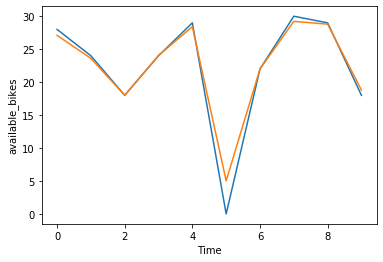


Station 42 	 available_bike_stands
MAE:  0.8705244338498213
MSE:  1.808843504171633
RMSE:  1.3449325277394524
R2:  0.9773926276872914 



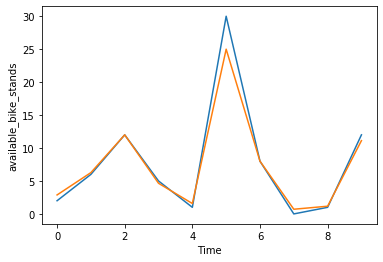


Station 30 	 available_bikes
MAE:  0.46027413587604293
MSE:  0.68737747318236
RMSE:  0.8290823078454636
R2:  0.9623874784267615 



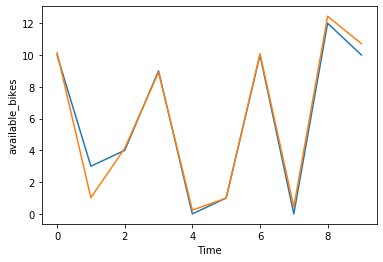


Station 30 	 available_bike_stands
MAE:  0.4651251489868892
MSE:  0.7033902264600715
RMSE:  0.8386836271563143
R2:  0.9614390445335048 



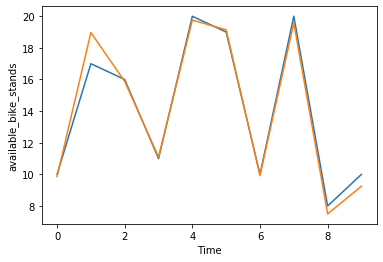


Station 54 	 available_bikes
MAE:  0.5204052443384982
MSE:  1.2381456495828367
RMSE:  1.1127199331291036
R2:  0.9738538604280008 



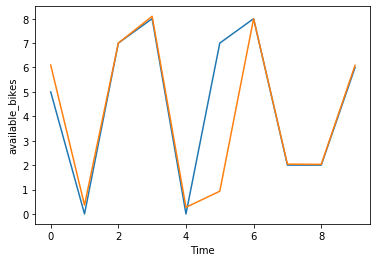


Station 54 	 available_bike_stands
MAE:  0.5224910607866509
MSE:  1.2542790226460072
RMSE:  1.1199459909504597
R2:  0.9735208680567407 



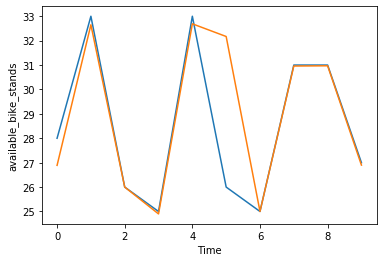


Station 108 	 available_bikes
MAE:  0.5127890345649584
MSE:  1.1197860548271754
RMSE:  1.0581994400051322
R2:  0.9891088654359227 



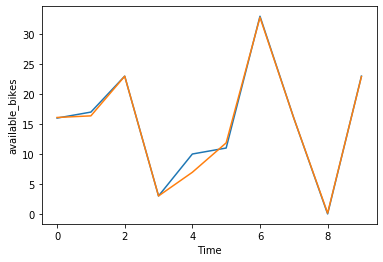


Station 108 	 available_bike_stands
MAE:  0.5140405244338498
MSE:  1.120074135876043
RMSE:  1.0583355497553897
R2:  0.9891095349631402 



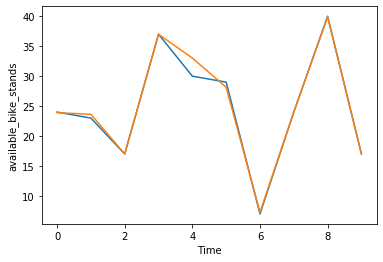


Station 56 	 available_bikes
MAE:  1.2205363528009534
MSE:  5.478939094159715
RMSE:  2.340713372918546
R2:  0.9455337862524459 



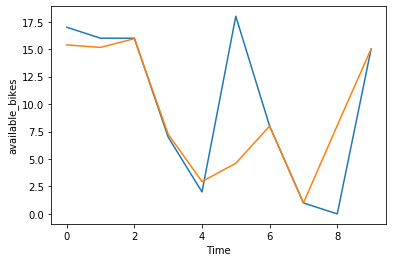


Station 56 	 available_bike_stands
MAE:  1.212777115613826
MSE:  5.411273420738975
RMSE:  2.3262143969847178
R2:  0.9470561887528935 



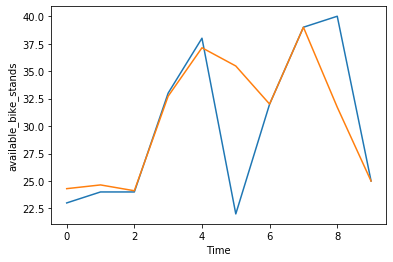


Station 6 	 available_bikes
MAE:  0.577938021454112
MSE:  0.9233243146603098
RMSE:  0.9608976608673319
R2:  0.9753788731164544 



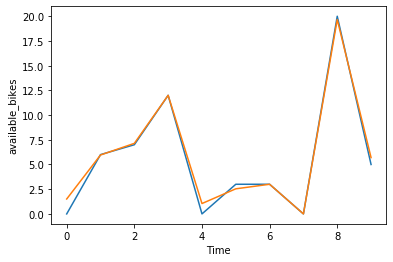


Station 6 	 available_bike_stands
MAE:  0.5836829558998808
MSE:  0.9483059594755662
RMSE:  0.973810022271062
R2:  0.9745994198333149 



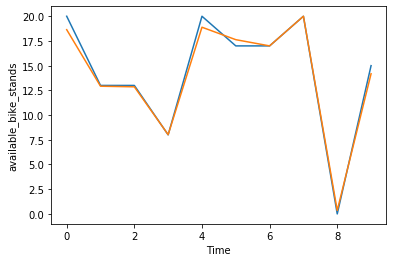


Station 18 	 available_bikes
MAE:  0.9376281287246723
MSE:  3.04596126340882
RMSE:  1.7452682496994036
R2:  0.9516213157193013 



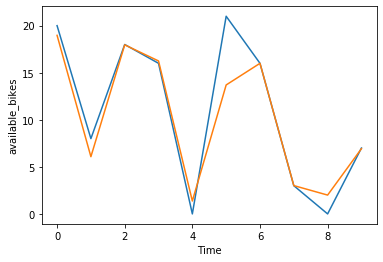


Station 18 	 available_bike_stands
MAE:  0.9393087008343267
MSE:  3.0216667461263405
RMSE:  1.738294205859969
R2:  0.9521685858482507 



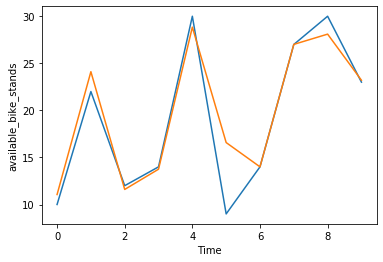


Station 32 	 available_bikes
MAE:  1.0832419547079857
MSE:  3.9734986889153756
RMSE:  1.9933636619832757
R2:  0.8962750265651089 



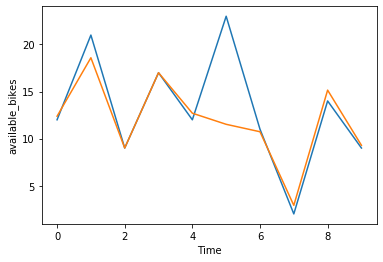


Station 32 	 available_bike_stands
MAE:  1.0988796185935639
MSE:  3.99318379022646
RMSE:  1.9982952209887457
R2:  0.8966054106366341 



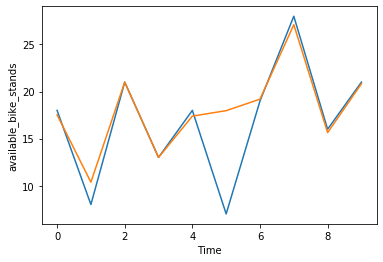


Station 52 	 available_bikes
MAE:  0.7533373063170441
MSE:  2.5478909415971396
RMSE:  1.5962114338636781
R2:  0.9609405227003817 



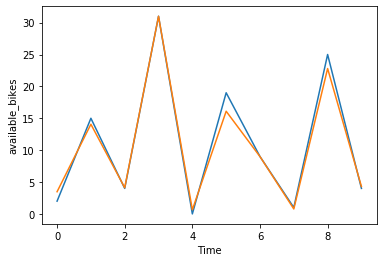


Station 52 	 available_bike_stands
MAE:  0.7554588796185935
MSE:  2.4564616209773535
RMSE:  1.5673103141935083
R2:  0.9625942858469848 



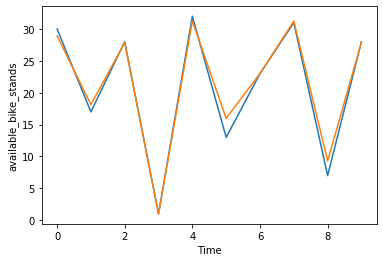


Station 48 	 available_bikes
MAE:  1.0049463647199046
MSE:  3.6203486293206195
RMSE:  1.902721374589727
R2:  0.9655794229358785 



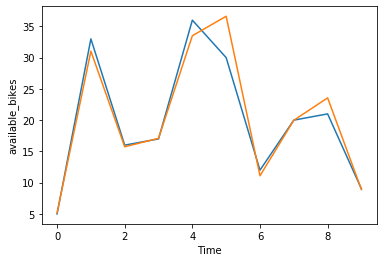


Station 48 	 available_bike_stands
MAE:  0.9983551847437427
MSE:  3.5751620977354
RMSE:  1.8908099052351615
R2:  0.9660010322095027 



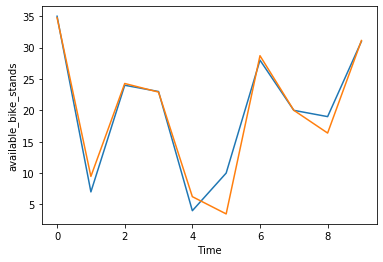


Station 13 	 available_bikes
MAE:  0.5024672228843862
MSE:  1.3055023837902264
RMSE:  1.1425858321326352
R2:  0.9774732903223624 



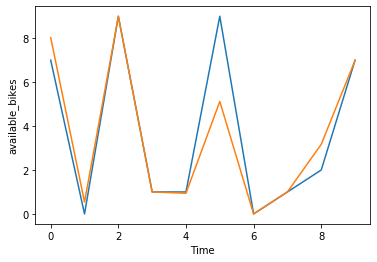


Station 13 	 available_bike_stands
MAE:  0.518772348033373
MSE:  1.3670172824791418
RMSE:  1.1691951430275196
R2:  0.9767662243107604 




Station 43 	 available_bikes
MAE:  1.062550655542312
MSE:  3.697713230035757
RMSE:  1.922943896746797
R2:  0.9472730276280716 




Station 43 	 available_bike_stands
MAE:  1.0660190703218118
MSE:  3.727307866507748
RMSE:  1.9306236988361425
R2:  0.9470501888932489 




Station 81 	 available_bikes
MAE:  0.40685339690107275
MSE:  0.7513066746126341
RMSE:  0.8667794844207113
R2:  0.9912073896804195 




Station 81 	 available_bike_stands
MAE:  0.4008939213349226
MSE:  0.7214825983313469
RMSE:  0.8494013175945437
R2:  0.9916573860506502 



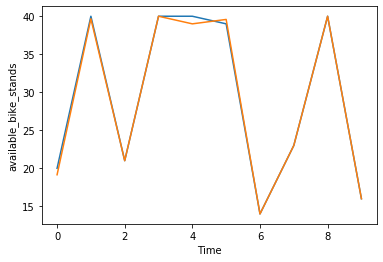


Station 31 	 available_bikes
MAE:  1.0296901072705602
MSE:  2.7089405244338494
RMSE:  1.645885939071675
R2:  0.9247746342700973 



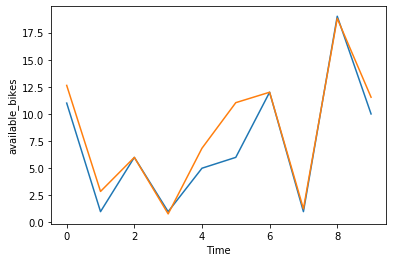


Station 31 	 available_bike_stands
MAE:  1.0396185935637663
MSE:  2.7682102502979737
RMSE:  1.6637939326424933
R2:  0.9232920676115837 



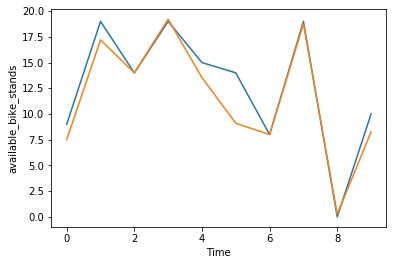


Station 98 	 available_bikes
MAE:  0.5243027413587603
MSE:  1.2099872467222885
RMSE:  1.0999942030403107
R2:  0.9883241388982273 



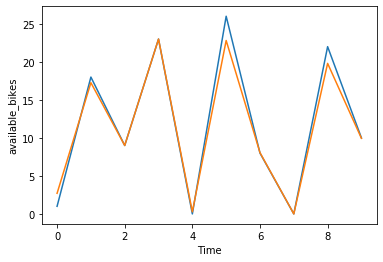


Station 98 	 available_bike_stands
MAE:  0.5313706793802146
MSE:  1.2523609058402858
RMSE:  1.1190893198669558
R2:  0.987938636984914 



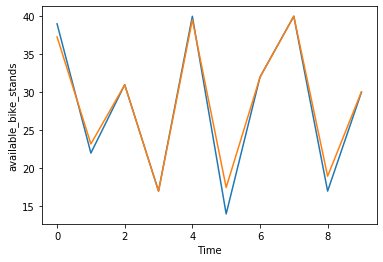


Station 23 	 available_bikes
MAE:  1.0967699642431468
MSE:  3.7922935637663886
RMSE:  1.9473812065865246
R2:  0.9382333952671091 



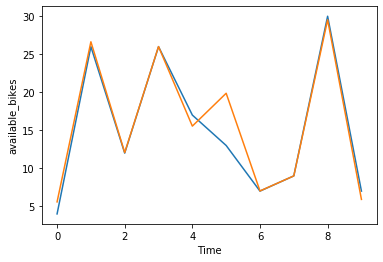


Station 23 	 available_bike_stands
MAE:  1.1065554231227652
MSE:  3.9776991656734215
RMSE:  1.9944169989431553
R2:  0.9360854474645997 



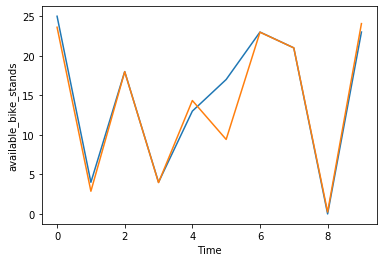


Station 106 	 available_bikes
MAE:  0.5793563766388559
MSE:  1.9553885578069132
RMSE:  1.3983520864957126
R2:  0.9756610553883062 



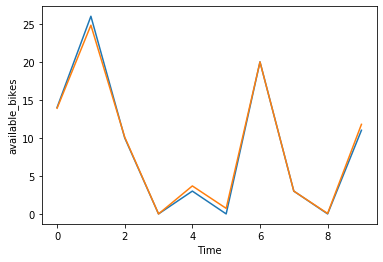


Station 106 	 available_bike_stands
MAE:  0.5797020262216925
MSE:  1.9660487485101308
RMSE:  1.402158603193708
R2:  0.9755264730451549 



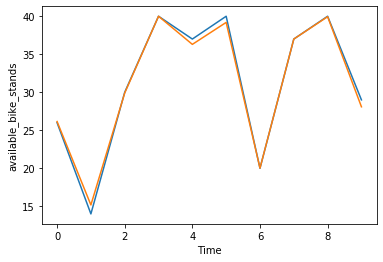


Station 112 	 available_bikes
MAE:  0.9467699642431466
MSE:  2.379770679380215
RMSE:  1.5426505370239285
R2:  0.9748885102451792 



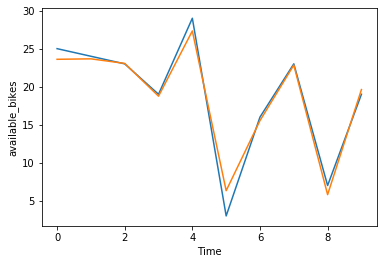


Station 112 	 available_bike_stands
MAE:  0.9517163289630513
MSE:  2.386104767580453
RMSE:  1.5447021614474594
R2:  0.9748201295061716 



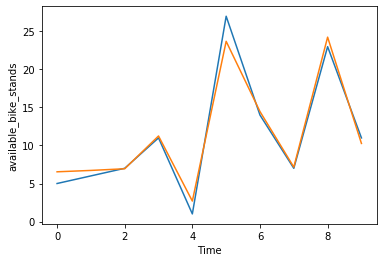


Station 68 	 available_bikes
MAE:  1.0685458879618595
MSE:  3.8246575685339685
RMSE:  1.95567317528619
R2:  0.9660272656384409 



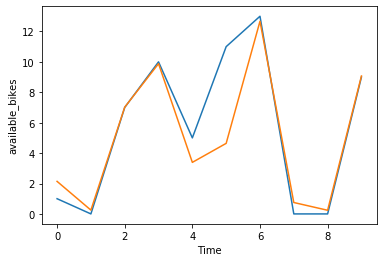


Station 68 	 available_bike_stands
MAE:  1.0566030989272943
MSE:  3.6846859356376642
RMSE:  1.919553577173001
R2:  0.9679694956525944 



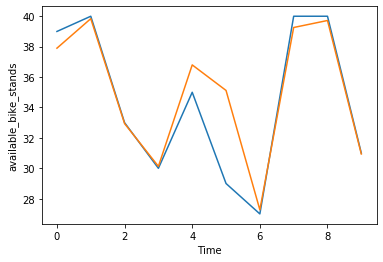


Station 74 	 available_bikes
MAE:  0.6258641239570919
MSE:  1.1398967818831942
RMSE:  1.0676594877971133
R2:  0.9794767095007401 



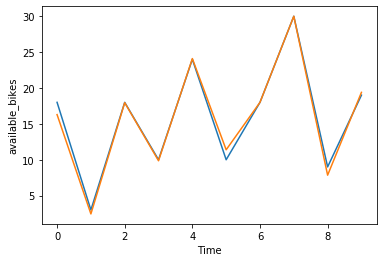


Station 74 	 available_bike_stands
MAE:  0.6252800953516091
MSE:  1.1503357568533972
RMSE:  1.07253706549163
R2:  0.979286468889523 



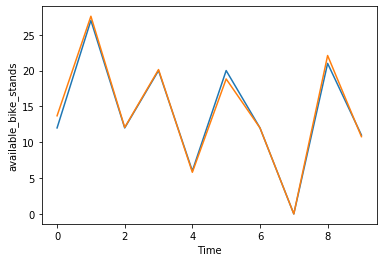


Station 87 	 available_bikes
MAE:  0.6010369487485101
MSE:  1.2309908224076282
RMSE:  1.1095002579574411
R2:  0.9847178168957623 



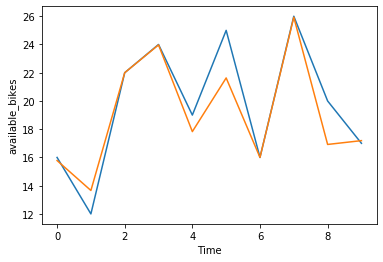


Station 87 	 available_bike_stands
MAE:  0.5987485101311085
MSE:  1.2191572109654352
RMSE:  1.104154523137697
R2:  0.9848448491563455 



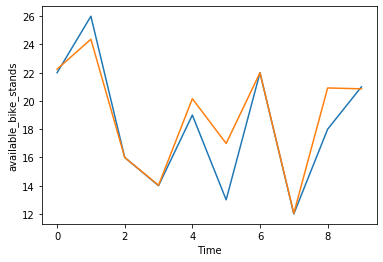


Station 84 	 available_bikes
MAE:  0.7318116805721097
MSE:  1.8646528009535162
RMSE:  1.3655229038553385
R2:  0.976906105013291 



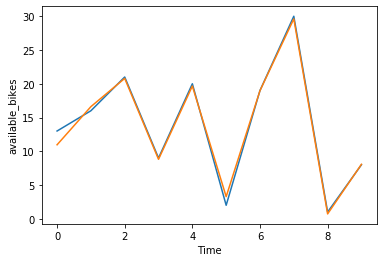


Station 84 	 available_bike_stands
MAE:  0.733933253873659
MSE:  1.8988902264600716
RMSE:  1.3780022592362
R2:  0.976516362944058 



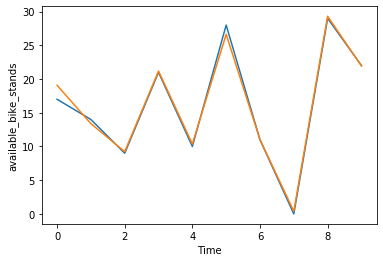


Station 90 	 available_bikes
MAE:  0.7293444576877236
MSE:  2.2879823599523244
RMSE:  1.5126078011012387
R2:  0.9801041967011702 



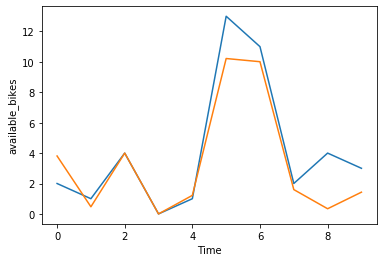


Station 90 	 available_bike_stands
MAE:  0.7278069129916569
MSE:  2.285152920143027
RMSE:  1.5116722264244413
R2:  0.9801784077267787 



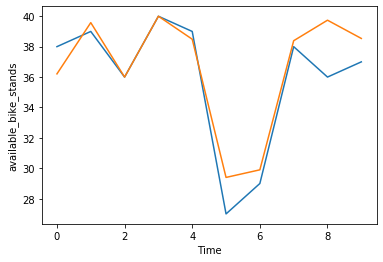


Station 11 	 available_bikes
MAE:  0.5466626936829558
MSE:  1.8253245530393325
RMSE:  1.3510457257396333
R2:  0.966204619376613 



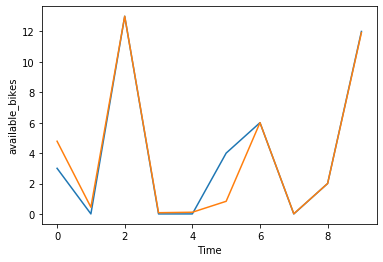


Station 11 	 available_bike_stands
MAE:  0.5396305125148987
MSE:  1.8542139451728248
RMSE:  1.361695246805549
R2:  0.9663733144858137 



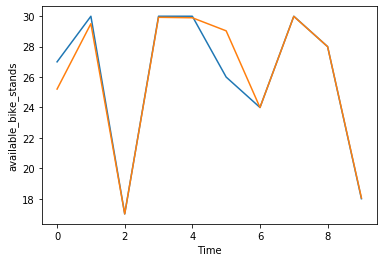


Station 17 	 available_bikes
MAE:  0.5303098927294397
MSE:  0.7906766388557807
RMSE:  0.8891999993566018
R2:  0.9683418646151354 



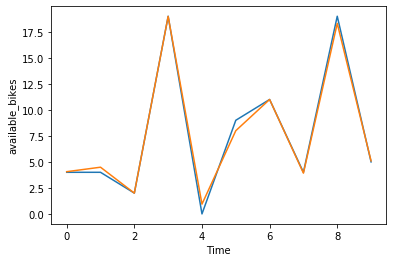


Station 17 	 available_bike_stands
MAE:  0.5313349225268176
MSE:  0.7820735399284864
RMSE:  0.8843492183116839
R2:  0.9686422421562314 



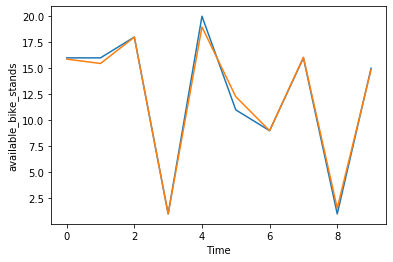


Station 45 	 available_bikes
MAE:  0.4874016686531586
MSE:  0.7767464839094159
RMSE:  0.8813322210775094
R2:  0.9909773670922447 



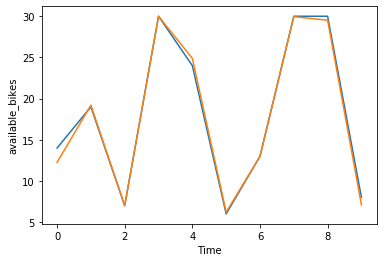


Station 45 	 available_bike_stands
MAE:  0.4864362336114422
MSE:  0.7491423122765198
RMSE:  0.8655300758936803
R2:  0.9912570335387695 



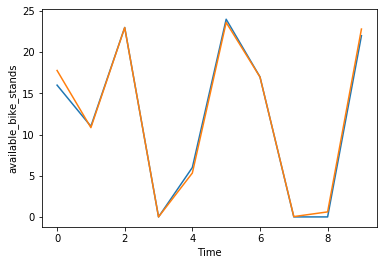


Station 114 	 available_bikes
MAE:  0.8596901072705602
MSE:  3.286759952324195
RMSE:  1.812942346663069
R2:  0.9646263774566963 



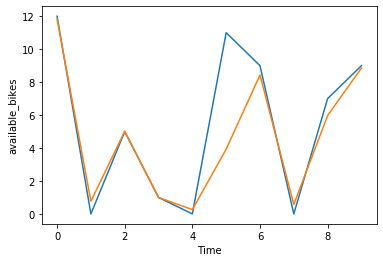


Station 114 	 available_bike_stands
MAE:  0.8468057210965435
MSE:  3.1744969010727058
RMSE:  1.7817117895643801
R2:  0.9661468675784197 



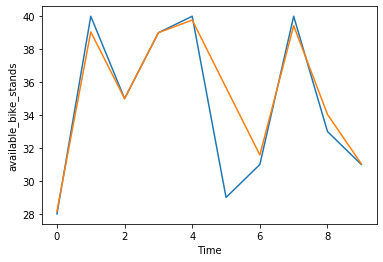


Station 72 	 available_bikes
MAE:  0.8268295589988082
MSE:  2.227952443384982
RMSE:  1.492632722200938
R2:  0.9671051773532126 



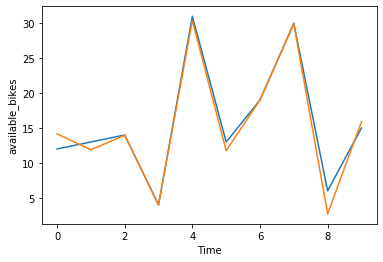


Station 72 	 available_bike_stands
MAE:  0.8383790226460073
MSE:  2.2651530393325388
RMSE:  1.505042537383093
R2:  0.9665324388143823 



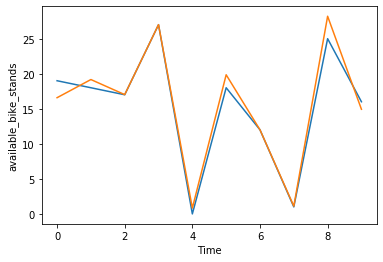


Station 63 	 available_bikes
MAE:  0.771549463647199
MSE:  2.404068772348033
RMSE:  1.5505059730126916
R2:  0.9645127507253994 



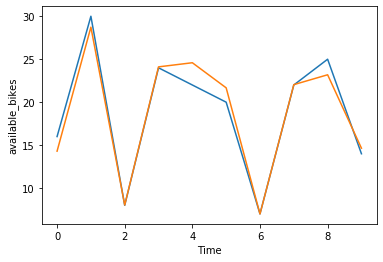


Station 63 	 available_bike_stands
MAE:  0.7672705601907033
MSE:  2.3998500595947556
RMSE:  1.549144944669399
R2:  0.9646864167036009 




Station 113 	 available_bikes
MAE:  0.470238379022646
MSE:  0.9352270560190704
RMSE:  0.9670713810361004
R2:  0.9916587415652145 




Station 113 	 available_bike_stands
MAE:  0.4707747318235995
MSE:  0.9689814064362336
RMSE:  0.9843685318193759
R2:  0.9913911178969906 



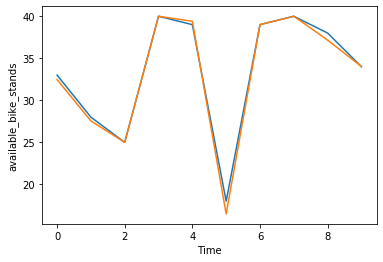


Station 91 	 available_bikes
MAE:  1.0738736591179976
MSE:  3.8466162097735395
RMSE:  1.9612792278952886
R2:  0.9446131944041307 



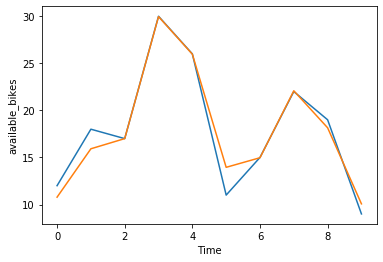


Station 91 	 available_bike_stands
MAE:  1.083301549463647
MSE:  3.8536582836710367
RMSE:  1.963073682690244
R2:  0.9445936221812034 



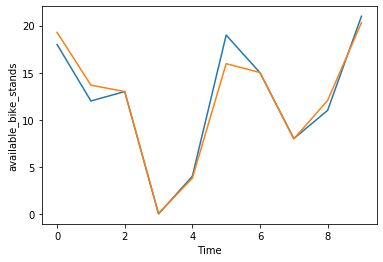


Station 99 	 available_bikes
MAE:  0.48324195470798564
MSE:  0.966666746126341
RMSE:  0.9831921206592031
R2:  0.988325696502398 



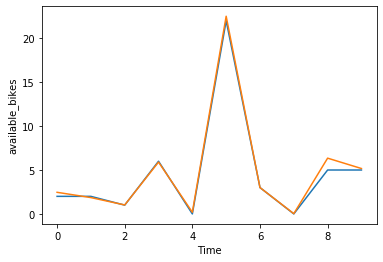


Station 99 	 available_bike_stands
MAE:  0.47824791418355184
MSE:  0.948522884386174
RMSE:  0.9739213953837209
R2:  0.988567600773948 



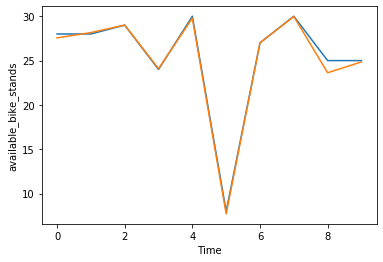


Station 9 	 available_bikes
MAE:  1.4145411203814064
MSE:  5.532143027413587
RMSE:  2.3520508131019593
R2:  0.9079497820096207 



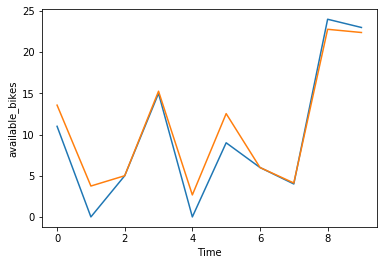


Station 9 	 available_bike_stands
MAE:  1.39927294398093
MSE:  5.49907663885578
RMSE:  2.3450110103911626
R2:  0.9094257974084871 



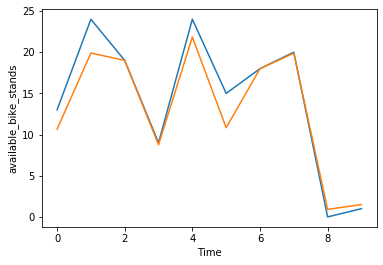


Station 67 	 available_bikes
MAE:  1.1365673420738975
MSE:  5.153479380214541
RMSE:  2.270127613200311
R2:  0.9525449301254625 



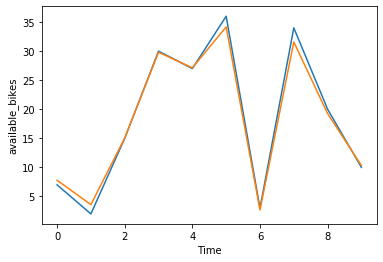


Station 67 	 available_bike_stands
MAE:  1.1340643623361146
MSE:  5.345044338498213
RMSE:  2.3119351934036154
R2:  0.9516721528411412 




Station 116 	 available_bikes
MAE:  0.17349225268176402
MSE:  0.12668915375446962
RMSE:  0.3559341986301255
R2:  0.9893577810178631 




Station 116 	 available_bike_stands
MAE:  0.19005959475566161
MSE:  0.25065768772348035
RMSE:  0.5006572557383747
R2:  0.9790392328669874 




Station 55 	 available_bikes
MAE:  0.4285935637663886
MSE:  1.0899166865315852
RMSE:  1.0439907502136143
R2:  0.9881373669952668 



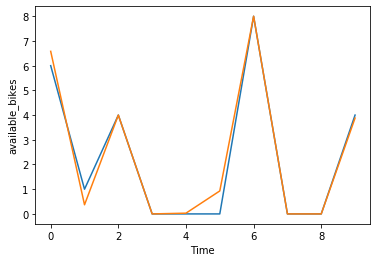


Station 55 	 available_bike_stands
MAE:  0.43202622169249094
MSE:  1.0956821215733015
RMSE:  1.046748356374779
R2:  0.9881037443421061 



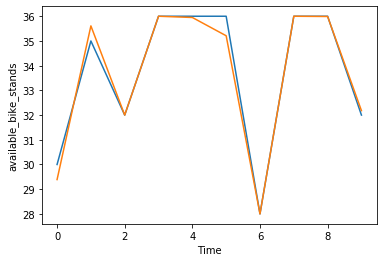


Station 62 	 available_bikes
MAE:  0.6193682955899881
MSE:  1.6196513706793803
RMSE:  1.2726552442352093
R2:  0.9850675896552382 



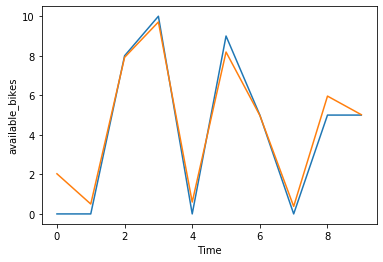


Station 62 	 available_bike_stands
MAE:  0.6213349225268175
MSE:  1.6013890345649582
RMSE:  1.2654600090737589
R2:  0.9854441706650546 



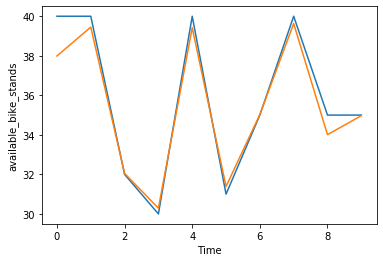


Station 5 	 available_bikes
MAE:  1.4021573301549461
MSE:  5.87868021454112
RMSE:  2.4245989801493195
R2:  0.9348794897386399 




Station 5 	 available_bike_stands
MAE:  1.3985578069129916
MSE:  5.83243611442193
RMSE:  2.4150437085945113
R2:  0.9354329255755063 



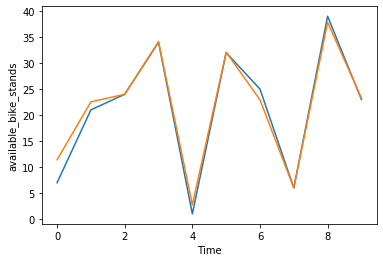


Station 97 	 available_bikes
MAE:  0.7733015494636472
MSE:  2.6225964243146604
RMSE:  1.6194432451662701
R2:  0.9744781396369424 




Station 97 	 available_bike_stands
MAE:  0.7828128724672231
MSE:  2.6763637663885578
RMSE:  1.6359595858053944
R2:  0.9739554509008024 




Station 61 	 available_bikes
MAE:  0.721704410011919
MSE:  2.2394144219308703
RMSE:  1.496467314020213
R2:  0.9571933933851653 




Station 61 	 available_bike_stands
MAE:  0.716233611442193
MSE:  2.206773539928486
RMSE:  1.4855213024149085
R2:  0.9578409218417621 



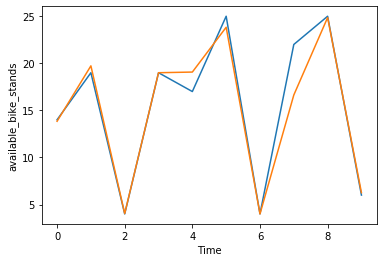


Station 77 	 available_bikes
MAE:  0.6507985697258641
MSE:  1.6302576877234805
RMSE:  1.2768154477932512
R2:  0.9803419906843891 



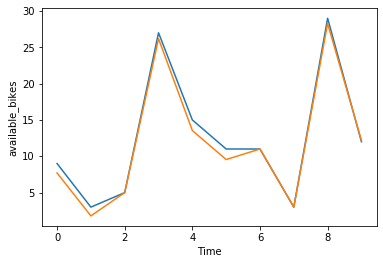


Station 77 	 available_bike_stands
MAE:  0.6526698450536355
MSE:  1.6439381406436235
RMSE:  1.282161511137978
R2:  0.9801792730416893 



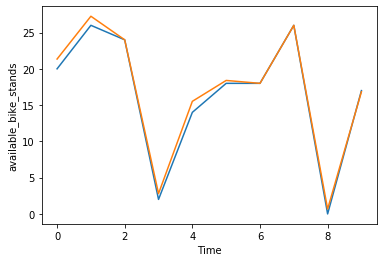


Station 73 	 available_bikes
MAE:  0.5440286054827176
MSE:  1.2326398092967819
RMSE:  1.1102431307136207
R2:  0.9804548572531431 



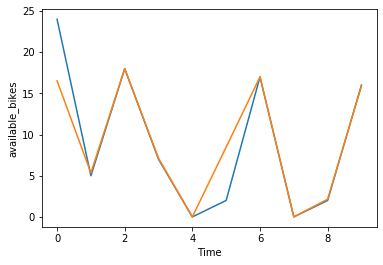


Station 73 	 available_bike_stands
MAE:  0.5348748510131108
MSE:  1.3623804529201426
RMSE:  1.1672105435268063
R2:  0.9812779289170239 



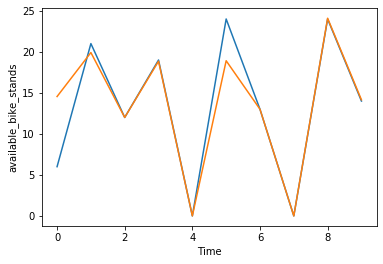


Station 4 	 available_bikes
MAE:  0.5483790226460071
MSE:  0.8411724672228844
RMSE:  0.9171545492570401
R2:  0.9769507354663685 




Station 4 	 available_bike_stands
MAE:  0.550715137067938
MSE:  0.8593607866507748
RMSE:  0.9270171447447856
R2:  0.9773460814684386 



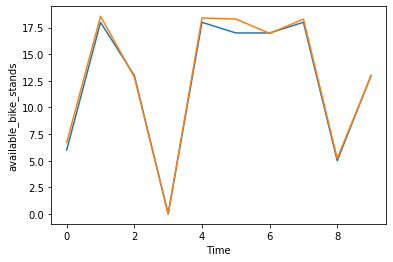


Station 49 	 available_bikes
MAE:  1.0199046483909417
MSE:  3.2998064362336117
RMSE:  1.8165369350039684
R2:  0.9716577236774687 



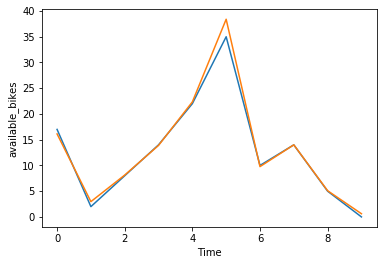


Station 49 	 available_bike_stands
MAE:  1.0343504171632896
MSE:  3.3348879618593563
RMSE:  1.8261675612767183
R2:  0.971446940480988 




Station 19 	 available_bikes
MAE:  1.1503456495828368
MSE:  4.03970989272944
RMSE:  2.009902956047739
R2:  0.9501749631152996 




Station 19 	 available_bike_stands
MAE:  1.1546483909415972
MSE:  4.064924791418355
RMSE:  2.016165864064352
R2:  0.9508767206992206 



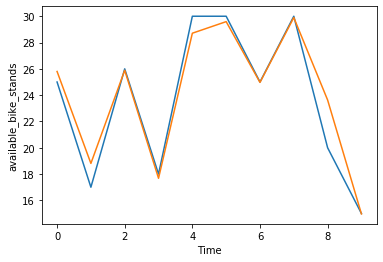


Station 7 	 available_bikes
MAE:  0.597497020262217
MSE:  2.0475904648390943
RMSE:  1.430940412749285
R2:  0.9674274129589431 



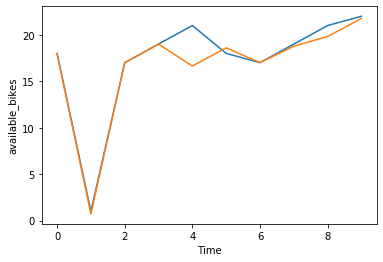


Station 7 	 available_bike_stands
MAE:  0.6038140643623361
MSE:  2.079112038140644
RMSE:  1.4419126319374014
R2:  0.9667477134902078 



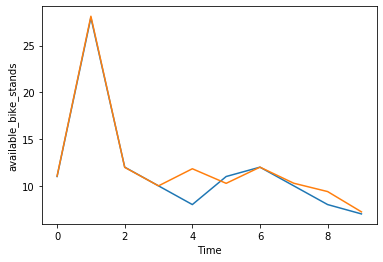


Station 102 	 available_bikes
MAE:  0.6225625744934445
MSE:  1.9834575685339693
RMSE:  1.4083527855384705
R2:  0.9624124055576976 



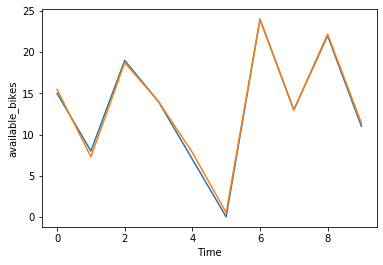


Station 102 	 available_bike_stands
MAE:  0.6220023837902264
MSE:  1.975424791418355
RMSE:  1.405498058133968
R2:  0.9627415928796174 



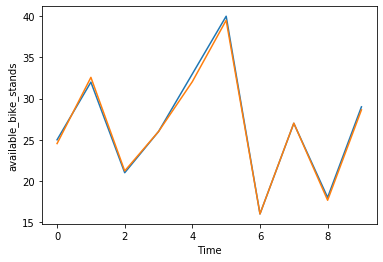


Station 38 	 available_bikes
MAE:  1.0218355184743741
MSE:  2.8631938021454117
RMSE:  1.6920974564561617
R2:  0.9700051983371422 



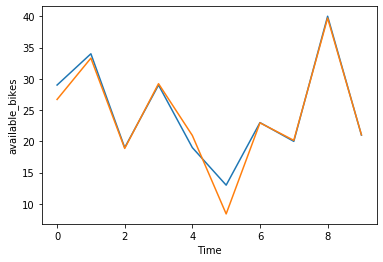


Station 38 	 available_bike_stands
MAE:  1.01342073897497
MSE:  2.8769137067938026
RMSE:  1.6961467232506162
R2:  0.9697272849560455 



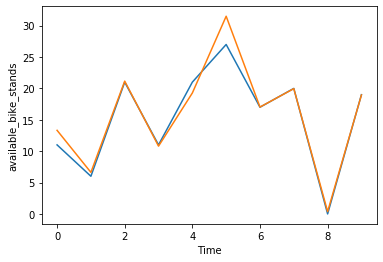


Station 53 	 available_bikes
MAE:  0.6145649582836711
MSE:  2.0473444576877236
RMSE:  1.4308544502106857
R2:  0.976616507273524 



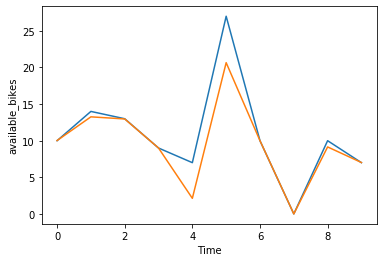


Station 53 	 available_bike_stands
MAE:  0.6227890345649583
MSE:  2.0966200238379025
RMSE:  1.4479710024161059
R2:  0.9764411934666729 



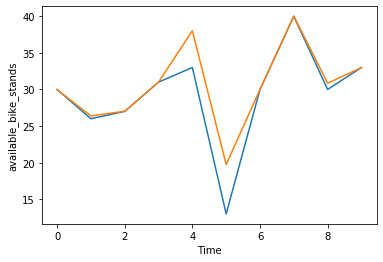


Station 58 	 available_bikes
MAE:  1.1886412395709178
MSE:  4.954091179976162
RMSE:  2.225778780556631
R2:  0.9499251981825803 



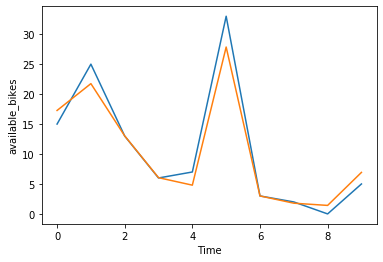


Station 58 	 available_bike_stands
MAE:  1.1976996424314659
MSE:  5.007670441001191
RMSE:  2.2377824829507427
R2:  0.9498293447712037 



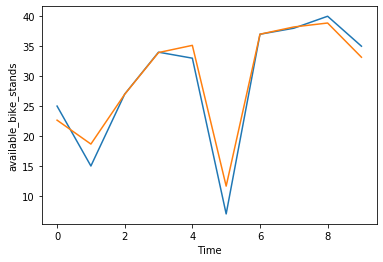


Station 66 	 available_bikes
MAE:  1.2096305125148985
MSE:  4.591958998808105
RMSE:  2.1428856709605637
R2:  0.9428833487523267 



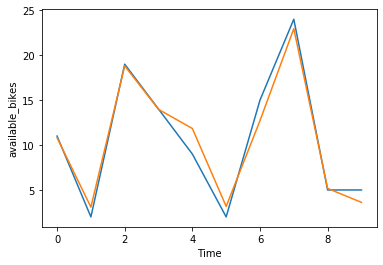


Station 66 	 available_bike_stands
MAE:  1.2327771156138263
MSE:  4.661125148986888
RMSE:  2.1589639063650155
R2:  0.9441261959119835 




Station 104 	 available_bikes
MAE:  0.38501787842669843
MSE:  0.981415852205006
RMSE:  0.9906643489118835
R2:  0.9692604775595095 



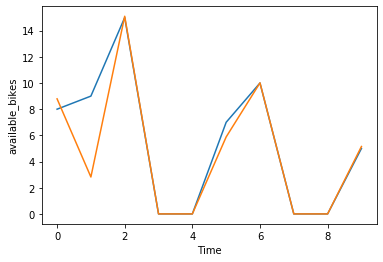


Station 104 	 available_bike_stands
MAE:  0.394123957091776
MSE:  1.0213429082240764
RMSE:  1.0106151137916335
R2:  0.968626272237021 



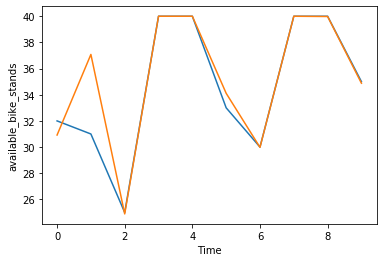


Station 101 	 available_bikes
MAE:  0.6317163289630514
MSE:  1.2162573301549464
RMSE:  1.1028405733173523
R2:  0.976544896808941 



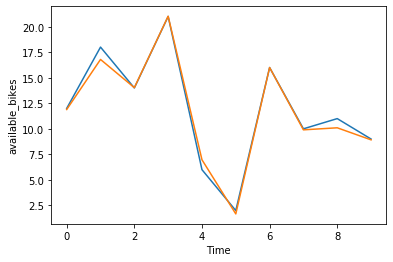


Station 101 	 available_bike_stands
MAE:  0.6335041716328963
MSE:  1.2894129916567343
RMSE:  1.1355232237416961
R2:  0.9751871402231231 




Station 115 	 available_bikes
MAE:  0.9175566150178783
MSE:  2.5464053635280095
RMSE:  1.5957460209970789
R2:  0.9698687270216602 



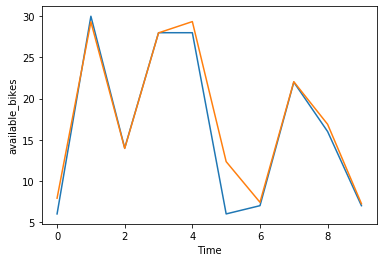


Station 115 	 available_bike_stands
MAE:  0.9190703218116806
MSE:  2.5520307508939215
RMSE:  1.5975076684929939
R2:  0.9697088112158609 




Station 47 	 available_bikes
MAE:  0.5770679380214542
MSE:  2.70546126340882
RMSE:  1.6448286425670062
R2:  0.9789499796698844 



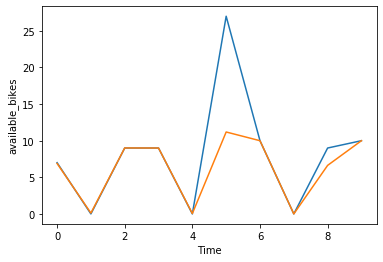


Station 47 	 available_bike_stands
MAE:  0.5809296781883194
MSE:  2.7742238379022646
RMSE:  1.6656001434624892
R2:  0.9784980351923969 



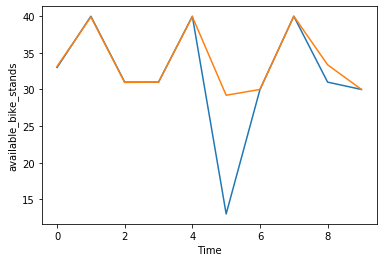


Station 117 	 available_bikes
MAE:  0.43169249106078667
MSE:  2.531648510131109
RMSE:  1.5911154923923998
R2:  0.9714355776704148 



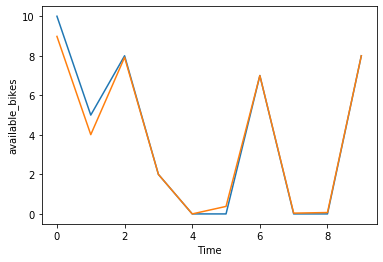


Station 117 	 available_bike_stands
MAE:  0.43488676996424314
MSE:  2.4947152562574493
RMSE:  1.5794667632645676
R2:  0.9718763956780342 



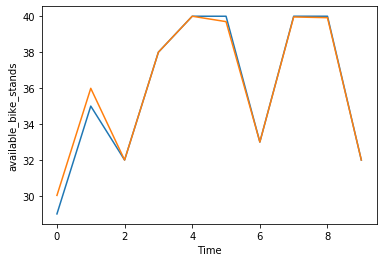


Station 8 	 available_bikes
MAE:  0.8949106078665077
MSE:  2.3891402860548276
RMSE:  1.545684407003845
R2:  0.9631012023550939 



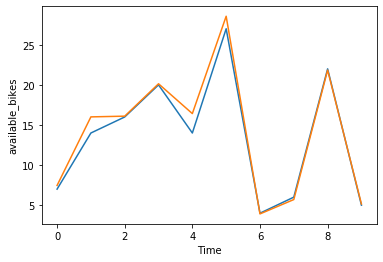


Station 8 	 available_bike_stands
MAE:  0.8839809296781884
MSE:  2.354858402860548
RMSE:  1.5345547897877574
R2:  0.9636159349383139 



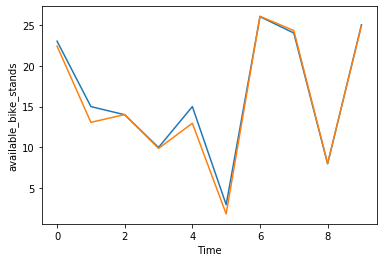


Station 27 	 available_bikes
MAE:  0.6857806912991656
MSE:  1.5190325387365913
RMSE:  1.2324903807886662
R2:  0.9666894918491227 



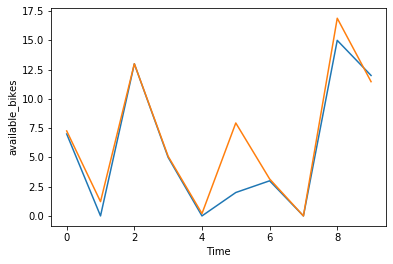


Station 27 	 available_bike_stands
MAE:  0.6930631704410012
MSE:  1.5486488676996424
RMSE:  1.2444472137056044
R2:  0.9661803218738668 



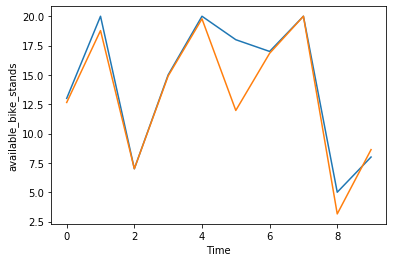


Station 16 	 available_bikes
MAE:  0.5752920143027414
MSE:  1.0575393325387366
RMSE:  1.028367314017096
R2:  0.968425136216263 



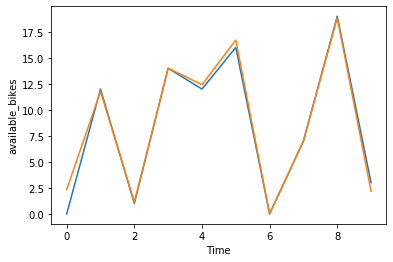


Station 16 	 available_bike_stands
MAE:  0.5767699642431466
MSE:  1.0917009535160904
RMSE:  1.0448449423316795
R2:  0.9676435374672392 



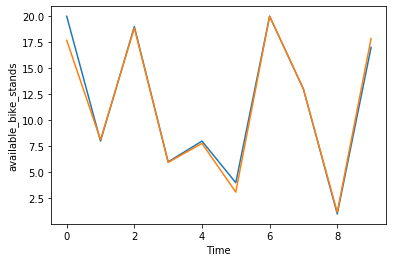


Station 96 	 available_bikes
MAE:  0.29349225268176404
MSE:  0.39201978545887955
RMSE:  0.6261148340830774
R2:  0.9952947243565501 



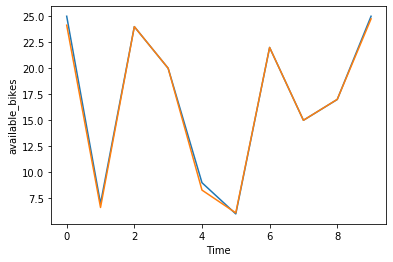


Station 96 	 available_bike_stands
MAE:  0.29342073897497023
MSE:  0.39398545887961856
RMSE:  0.6276826099866226
R2:  0.9952715430661228 



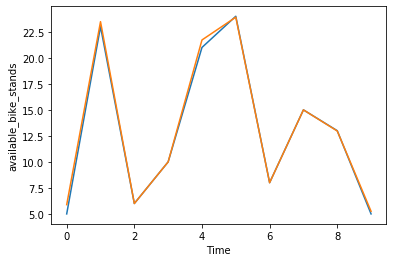


Station 82 	 available_bikes
MAE:  0.3847199046483909
MSE:  0.4903320619785459
RMSE:  0.7002371469570476
R2:  0.9879246367193163 



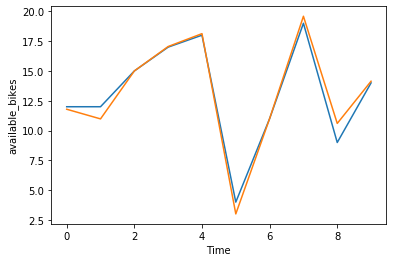


Station 82 	 available_bike_stands
MAE:  0.3898569725864123
MSE:  0.4943932061978546
RMSE:  0.7031310021595226
R2:  0.9878641623809906 



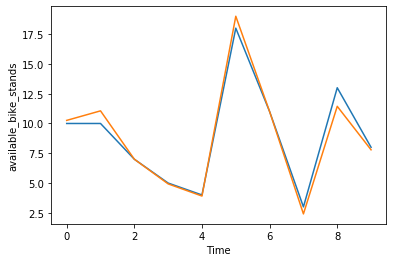


Station 76 	 available_bikes
MAE:  0.7174374255065555
MSE:  2.1106988081048867
RMSE:  1.4528244243902588
R2:  0.9721074032473315 



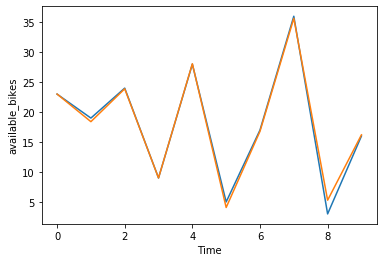


Station 76 	 available_bike_stands
MAE:  0.7027294398092969
MSE:  1.9243245530393327
RMSE:  1.3872002570066562
R2:  0.9738037337284345 



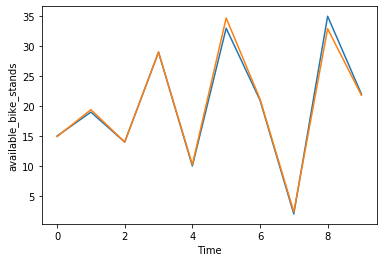


Station 71 	 available_bikes
MAE:  0.7183194278903458
MSE:  1.382447556615018
RMSE:  1.1757753002232263
R2:  0.9793966765313299 



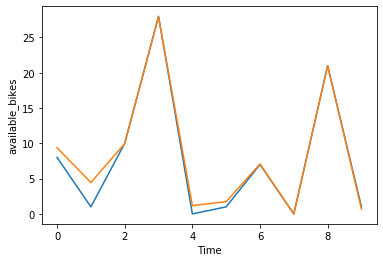


Station 71 	 available_bike_stands
MAE:  0.7264243146603099
MSE:  1.4332637663885575
RMSE:  1.1971899458267086
R2:  0.9785737775607345 



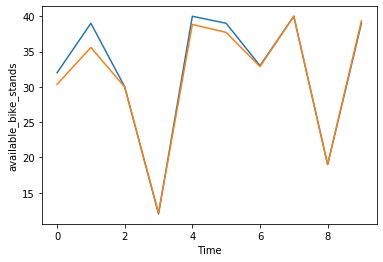


Station 79 	 available_bikes
MAE:  0.6550655542312277
MSE:  2.3481218116805724
RMSE:  1.5323582517416
R2:  0.962236344206015 



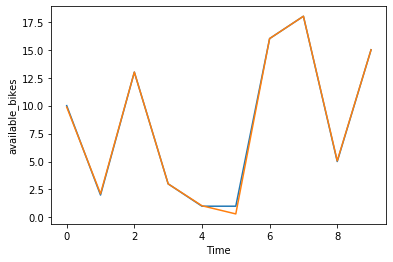


Station 79 	 available_bike_stands
MAE:  0.6530631704410013
MSE:  2.3637139451728246
RMSE:  1.5374374605728927
R2:  0.9620052142849999 



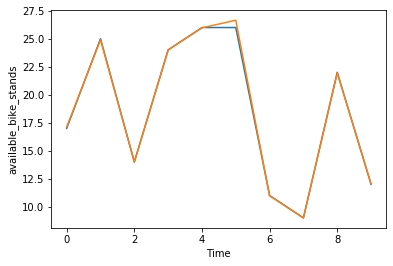


Station 69 	 available_bikes
MAE:  1.533766388557807
MSE:  6.867226817640048
RMSE:  2.62053941348724
R2:  0.9482154082718737 



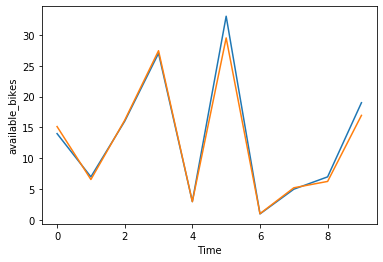


Station 69 	 available_bike_stands
MAE:  1.5258045292014304
MSE:  6.863207032181168
RMSE:  2.6197723244933266
R2:  0.9491160458125371 



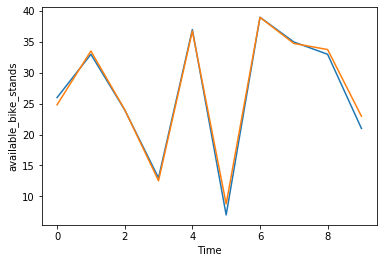


Station 25 	 available_bikes
MAE:  0.6458879618593563
MSE:  1.6472390941597137
RMSE:  1.2834481267895925
R2:  0.9767790651268528 



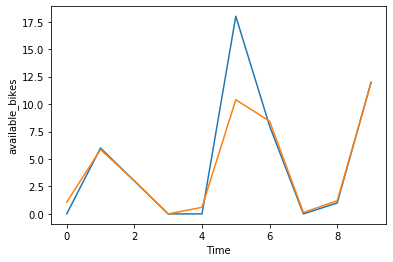


Station 25 	 available_bike_stands
MAE:  0.6569129916567342
MSE:  1.6749648390941598
RMSE:  1.2942043266401793
R2:  0.9767612796129654 



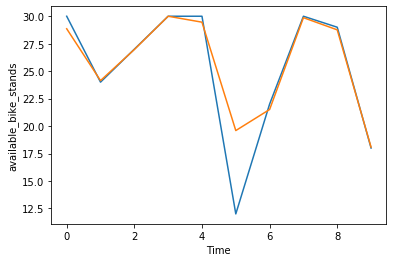


Station 51 	 available_bikes
MAE:  0.7490584028605484
MSE:  2.9113432657926106
RMSE:  1.7062658836748188
R2:  0.971861047867049 



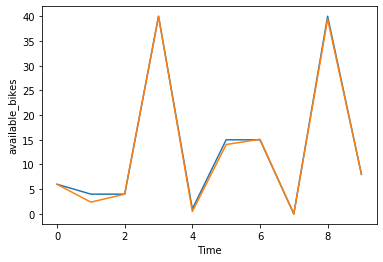


Station 51 	 available_bike_stands
MAE:  0.7570441001191897
MSE:  3.0951425506555426
RMSE:  1.7593017224613698
R2:  0.9700787585834866 



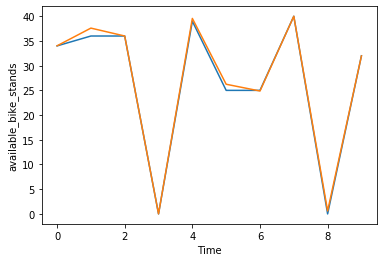


Station 37 	 available_bikes
MAE:  0.5620619785458879
MSE:  1.5042494636471988
RMSE:  1.2264784807110147
R2:  0.9592197226985414 



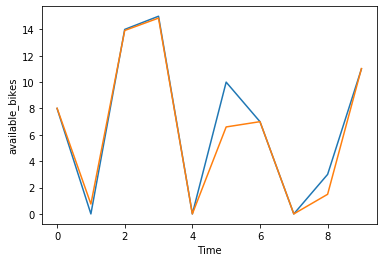


Station 37 	 available_bike_stands
MAE:  0.5543384982121574
MSE:  1.4817998808104886
RMSE:  1.2172920277445707
R2:  0.959987047342156 



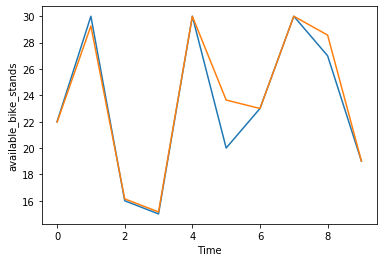


Station 59 	 available_bikes
MAE:  0.5047437425506556
MSE:  0.9232898688915376
RMSE:  0.9608797369554307
R2:  0.96105451396217 



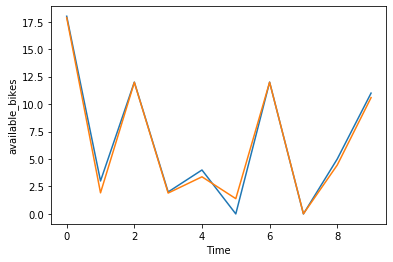


Station 59 	 available_bike_stands
MAE:  0.5061263408820024
MSE:  0.9206502979737782
RMSE:  0.9595052360324972
R2:  0.9620796631888784 



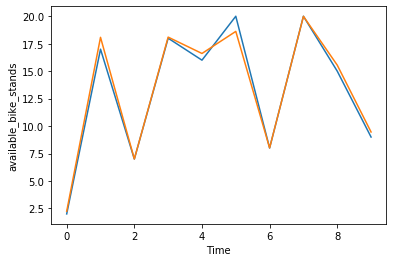


Station 95 	 available_bikes
MAE:  0.6706436233611441
MSE:  1.7289581644815253
RMSE:  1.3148985377136615
R2:  0.9820443925818678 



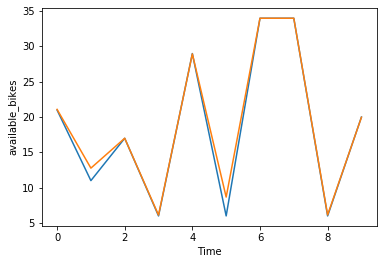


Station 95 	 available_bike_stands
MAE:  0.674410011918951
MSE:  1.6910499404052444
RMSE:  1.300403760531799
R2:  0.9824733745557629 



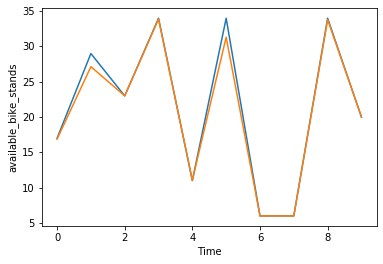


Station 94 	 available_bikes
MAE:  0.40830750893921336
MSE:  1.9375984505363528
RMSE:  1.3919764547349043
R2:  0.9881929940152117 



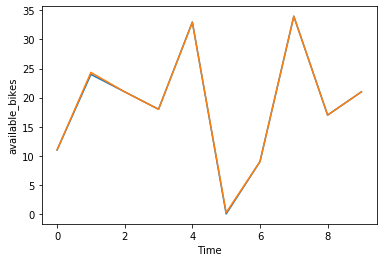


Station 94 	 available_bike_stands
MAE:  0.41276519666269373
MSE:  1.9389140643623362
RMSE:  1.392448944975124
R2:  0.9882104637915683 



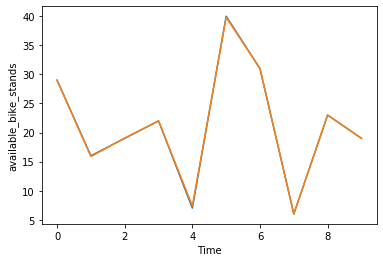


Station 105 	 available_bikes
MAE:  0.37165673420738965
MSE:  0.7970569725864125
RMSE:  0.8927804727851144
R2:  0.9837432652864669 



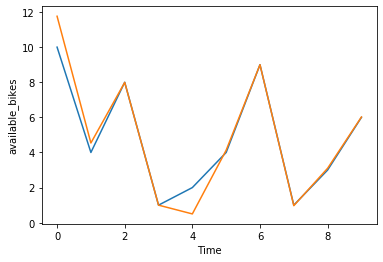


Station 105 	 available_bike_stands
MAE:  0.37591179976162103
MSE:  0.8046673420738973
RMSE:  0.8970325200759989
R2:  0.9836778455942172 



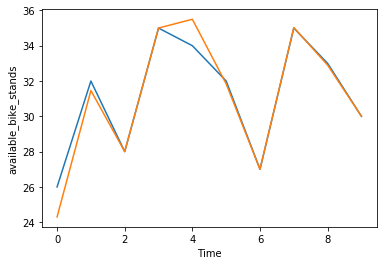


Station 36 	 available_bikes
MAE:  0.6943384982121573
MSE:  1.6811233611442193
RMSE:  1.2965814132341322
R2:  0.9832896347312395 



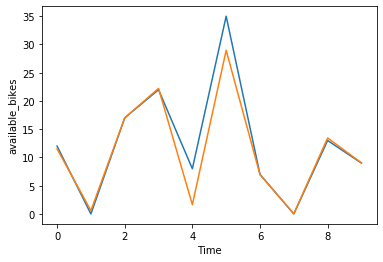


Station 36 	 available_bike_stands
MAE:  0.7044576877234803
MSE:  1.7684526817640047
RMSE:  1.3298318246169343
R2:  0.9828225237801297 



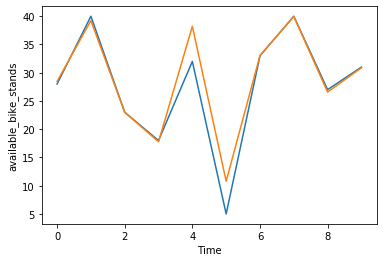


Station 93 	 available_bikes
MAE:  0.7094755661501788
MSE:  4.703919547079857
RMSE:  2.1688521266051906
R2:  0.9749684265394989 



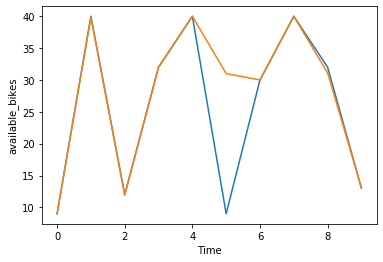


Station 93 	 available_bike_stands
MAE:  0.7165435041716329
MSE:  4.798898450536353
RMSE:  2.1906388224753877
R2:  0.9744711734889133 



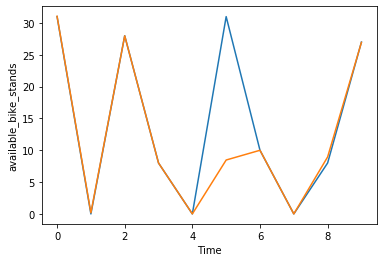


Station 22 	 available_bikes
MAE:  0.825876042908224
MSE:  2.1266849821215734
RMSE:  1.4583158032887025
R2:  0.9193748096525436 



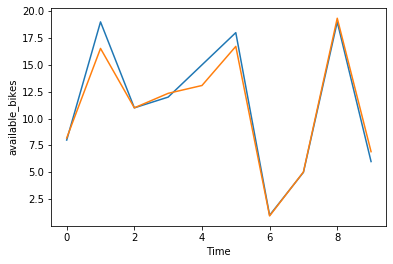


Station 22 	 available_bike_stands
MAE:  0.8201668653158523
MSE:  2.1098710369487486
RMSE:  1.4525395130421577
R2:  0.9206327411535621 



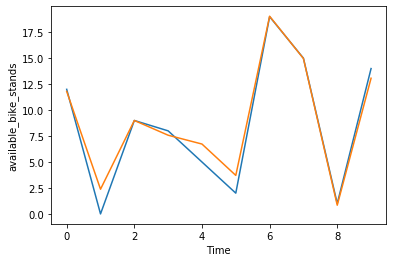


Station 50 	 available_bikes
MAE:  0.7996901072705601
MSE:  1.6284636471990463
RMSE:  1.2761127094418605
R2:  0.9803388447846395 



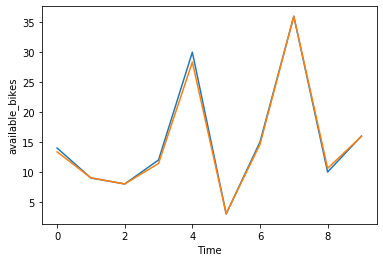


Station 50 	 available_bike_stands
MAE:  0.797175208581645
MSE:  1.6647526817640053
RMSE:  1.290252952627509
R2:  0.9799480203755484 



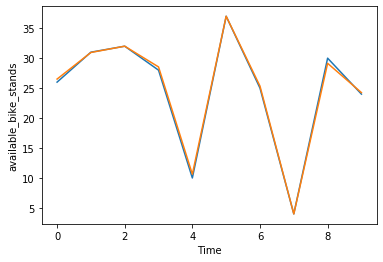


Station 110 	 available_bikes
MAE:  0.5994517282479143
MSE:  1.390541358760429
RMSE:  1.1792121771591526
R2:  0.9710471388932173 



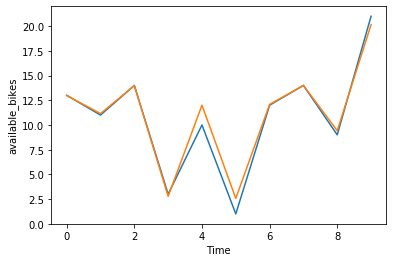


Station 110 	 available_bike_stands
MAE:  0.594803337306317
MSE:  1.3639578069129916
RMSE:  1.1678860419206112
R2:  0.9716972384219149 



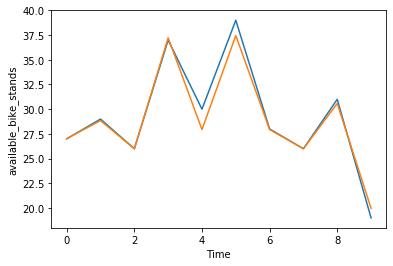


Station 12 	 available_bikes
MAE:  0.5566388557806913
MSE:  0.9041134684147795
RMSE:  0.9508488146991505
R2:  0.973851532835403 



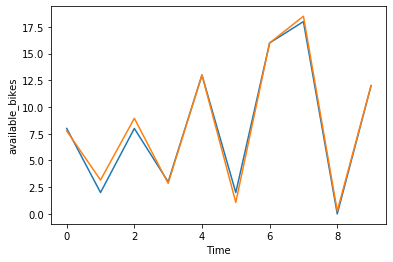


Station 12 	 available_bike_stands
MAE:  0.5621692491060787
MSE:  0.929754231227652
RMSE:  0.9642376425071011
R2:  0.9734313369697135 



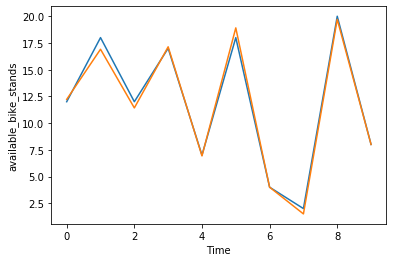


Station 34 	 available_bikes
MAE:  1.3888676996424314
MSE:  5.606354231227652
RMSE:  2.367774108995124
R2:  0.9389758909189794 



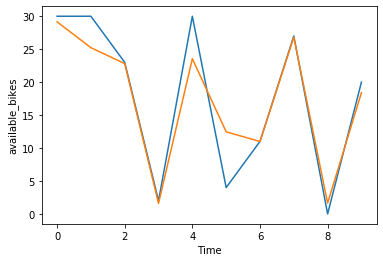


Station 34 	 available_bike_stands
MAE:  1.3982240762812874
MSE:  5.6811660309892735
RMSE:  2.383519672876495
R2:  0.9382110383956018 



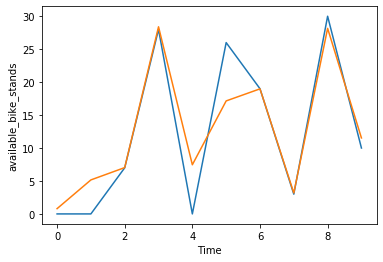


Station 78 	 available_bikes
MAE:  0.8149821215733015
MSE:  2.3002017878426697
RMSE:  1.5166416148328088
R2:  0.9810315373094854 



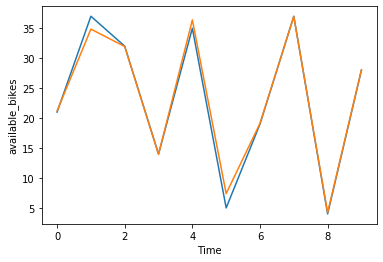


Station 78 	 available_bike_stands
MAE:  0.8215017878426698
MSE:  2.30116305125149
RMSE:  1.516958486990165
R2:  0.98106344156081 



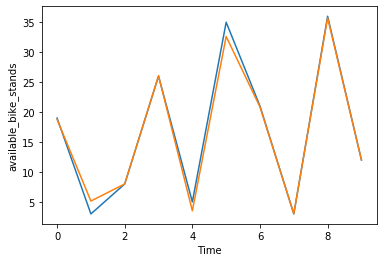


Station 2 	 available_bikes
MAE:  0.5568533969010726
MSE:  1.066833611442193
RMSE:  1.0328763776184413
R2:  0.9624784312528305 



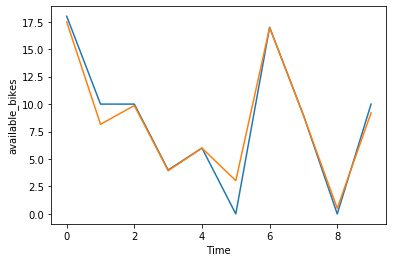


Station 2 	 available_bike_stands
MAE:  0.5546960667461264
MSE:  1.059149106078665
RMSE:  1.0291497005191543
R2:  0.9627487027302128 



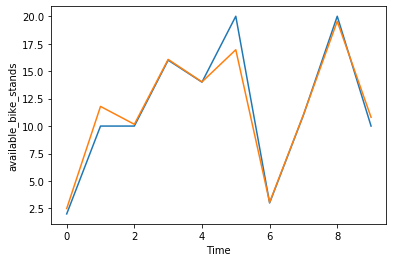


Station 75 	 available_bikes
MAE:  0.7855899880810491
MSE:  2.7625076281287244
RMSE:  1.6620793086157846
R2:  0.9680003718323474 



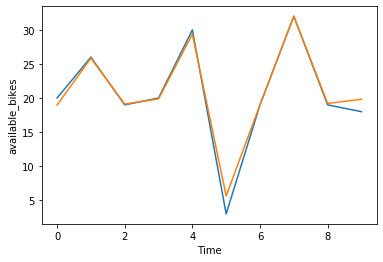


Station 75 	 available_bike_stands
MAE:  0.7885458879618592
MSE:  2.7943107270560192
RMSE:  1.6716191931944366
R2:  0.9676138934759294 



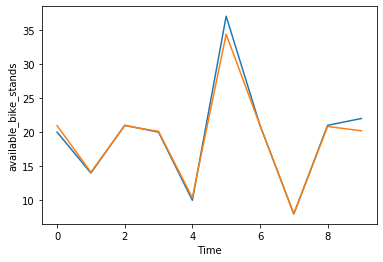


Station 111 	 available_bikes
MAE:  0.9351609058402862
MSE:  2.8142019070321815
RMSE:  1.6775583170287052
R2:  0.9749335050200413 



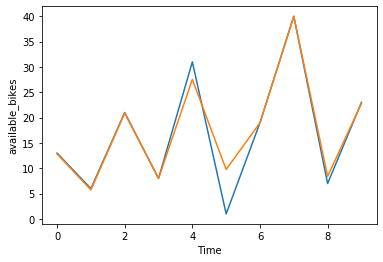


Station 111 	 available_bike_stands
MAE:  0.9304290822407629
MSE:  2.7470666269368302
RMSE:  1.6574277139401374
R2:  0.9756011320114553 



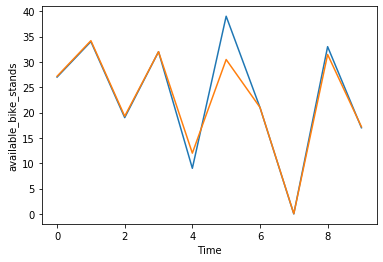


Station 26 	 available_bikes
MAE:  0.5750893921334923
MSE:  1.042313945172825
RMSE:  1.0209377773267208
R2:  0.9714772853417983 




Station 26 	 available_bike_stands
MAE:  0.5827771156138261
MSE:  1.0814189511323005
RMSE:  1.0399129536323222
R2:  0.9710040237764157 



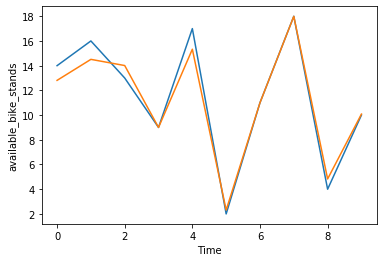


Station 65 	 available_bikes
MAE:  0.849642431466031
MSE:  3.0994339690107275
RMSE:  1.7605209368282808
R2:  0.9703246330528131 



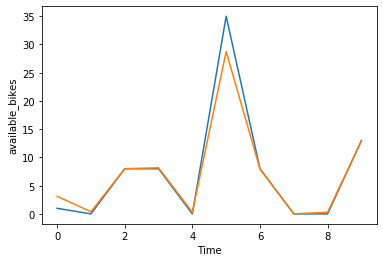


Station 65 	 available_bike_stands
MAE:  0.8708820023837903
MSE:  3.257711442193087
RMSE:  1.8049131397917981
R2:  0.9695247330743019 



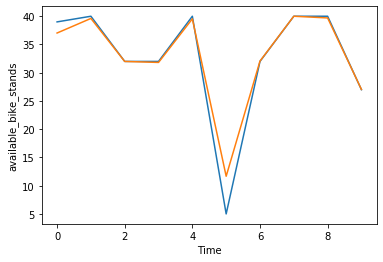


Station 15 	 available_bikes
MAE:  0.4513825983313468
MSE:  0.6296487485101311
RMSE:  0.7935040948288364
R2:  0.9609767134358346 



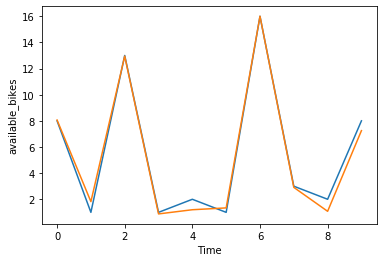


Station 15 	 available_bike_stands
MAE:  0.47537544696066736
MSE:  0.683543504171633
RMSE:  0.8267668983284424
R2:  0.9580555439033643 



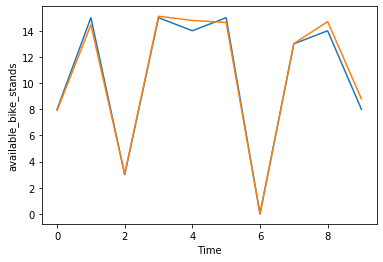


Station 86 	 available_bikes
MAE:  0.8472943980929678
MSE:  2.2466171632896303
RMSE:  1.4988719636078427
R2:  0.9865883348693507 



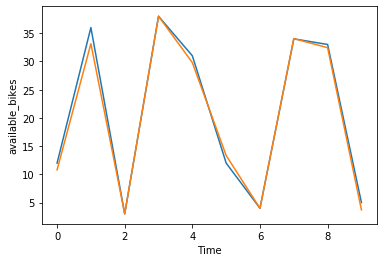


Station 86 	 available_bike_stands
MAE:  0.853611442193087
MSE:  2.245320381406436
RMSE:  1.4984393152231545
R2:  0.9865566434667642 




Station 10 	 available_bikes
MAE:  0.8716090584028605
MSE:  1.8898364719904648
RMSE:  1.3747132326381617
R2:  0.9343468010998071 



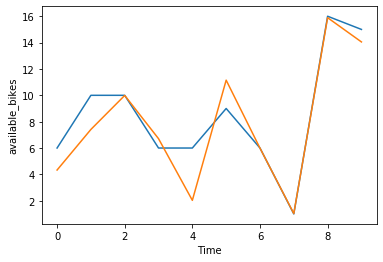


Station 10 	 available_bike_stands
MAE:  0.8707508939213349
MSE:  1.9054386174016686
RMSE:  1.3803762593588997
R2:  0.9343558647645269 



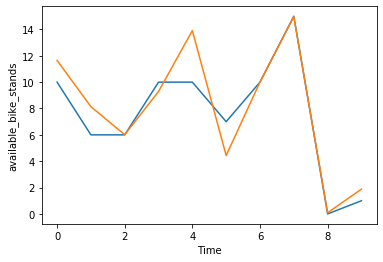


Station 100 	 available_bikes
MAE:  1.1028486293206197
MSE:  4.860778665077473
RMSE:  2.204717366257515
R2:  0.9233040849737518 



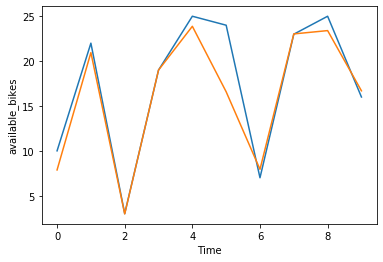


Station 100 	 available_bike_stands
MAE:  1.1062812872467223
MSE:  4.8811405244338495
RMSE:  2.2093303339324
R2:  0.9229308618204995 



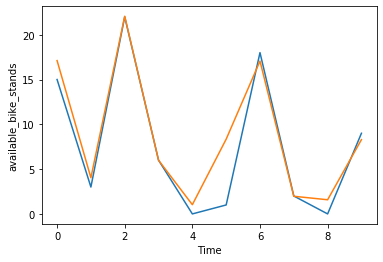


Station 24 	 available_bikes
MAE:  0.8140166865315852
MSE:  1.6913706793802146
RMSE:  1.300527077526729
R2:  0.9565628058019321 



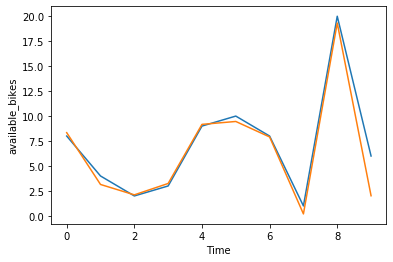


Station 24 	 available_bike_stands
MAE:  0.8027890345649582
MSE:  1.6664882002383794
RMSE:  1.290925327134912
R2:  0.9571338361370421 



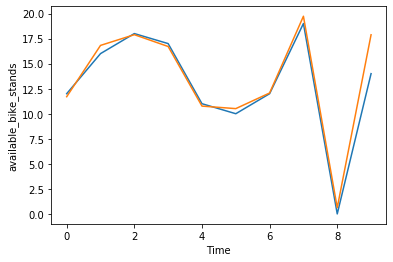


Station 64 	 available_bikes
MAE:  1.0190226460071514
MSE:  3.89987651966627
RMSE:  1.9748105022169267
R2:  0.9613567911262335 




Station 64 	 available_bike_stands
MAE:  1.017854588796186
MSE:  3.9420994040524437
RMSE:  1.9854720859413872
R2:  0.9612032582715584 



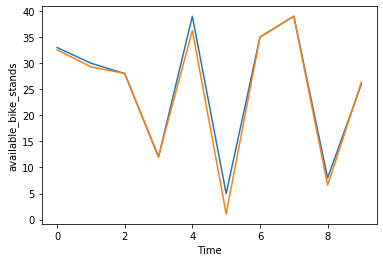


Station 109 	 available_bikes
MAE:  0.6430750893921334
MSE:  1.3765444576877233
RMSE:  1.1732623141001859
R2:  0.9782351131684613 




Station 109 	 available_bike_stands
MAE:  0.6490941597139451
MSE:  1.366848033373063
RMSE:  1.1691227623192797
R2:  0.978421954880173 




Station 85 	 available_bikes
MAE:  0.6441597139451729
MSE:  1.50511620977354
RMSE:  1.2268317772920376
R2:  0.9832014760187093 



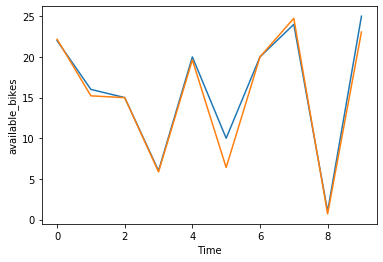


Station 85 	 available_bike_stands
MAE:  0.6379499404052443
MSE:  1.4868548271752084
RMSE:  1.219366568007836
R2:  0.9834152270271301 




Station 107 	 available_bikes
MAE:  0.7222407628128725
MSE:  2.1905845053635282
RMSE:  1.4800623315805075
R2:  0.9737814930478889 



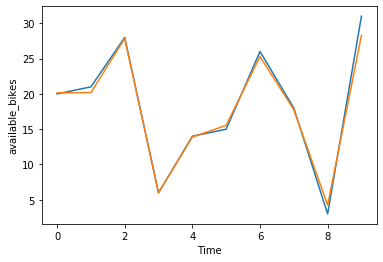


Station 107 	 available_bike_stands
MAE:  0.7305005959475566
MSE:  2.2143820023837897
RMSE:  1.488079971770264
R2:  0.9734824520859592 




Station 33 	 available_bikes
MAE:  1.2282002383790227
MSE:  4.005497020262217
RMSE:  2.001373783245453
R2:  0.9272505918404965 



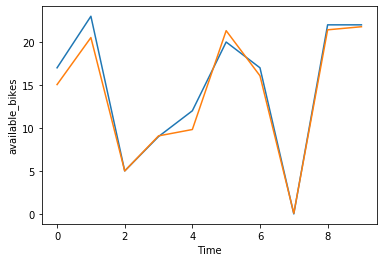


Station 33 	 available_bike_stands
MAE:  1.2337187127532776
MSE:  3.998297139451728
RMSE:  1.9995742395449407
R2:  0.927644609841094 



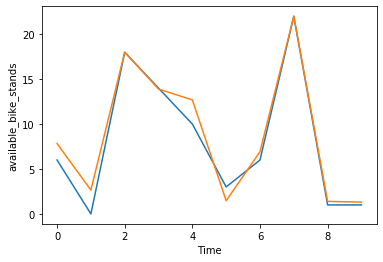


Station 44 	 available_bikes
MAE:  0.8998331346841478
MSE:  2.070435041716329
RMSE:  1.4389006364986878
R2:  0.9817520916279641 



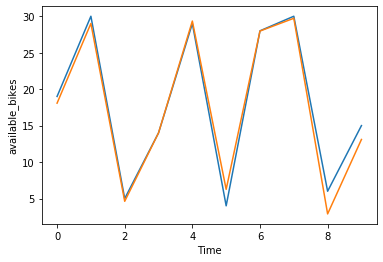


Station 44 	 available_bike_stands
MAE:  0.905792610250298
MSE:  2.0709451728247914
RMSE:  1.4390778897699705
R2:  0.9817392992623502 



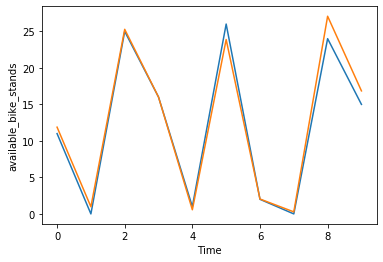


Station 89 	 available_bikes
MAE:  0.6619666269368295
MSE:  2.1197469606674613
RMSE:  1.4559350811995229
R2:  0.9570622199785193 



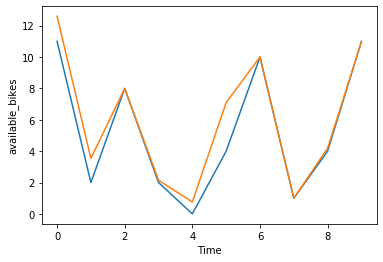


Station 89 	 available_bike_stands
MAE:  0.6617163289630513
MSE:  2.136682955899881
RMSE:  1.4617397018278873
R2:  0.956803733035183 



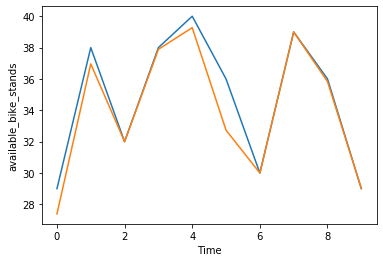


Station 57 	 available_bikes
MAE:  0.48561382598331343
MSE:  1.2785295589988082
RMSE:  1.1307208139053637
R2:  0.9669002372964687 



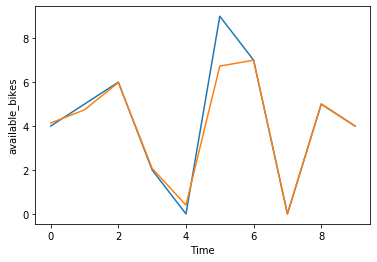


Station 57 	 available_bike_stands
MAE:  0.482777115613826
MSE:  1.2470783075089393
RMSE:  1.1167266037437003
R2:  0.9677711726614453 



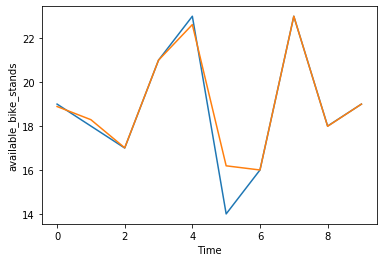


Station 80 	 available_bikes
MAE:  0.8018116805721097
MSE:  2.941100357568534
RMSE:  1.7149636607136998
R2:  0.9624522223551417 



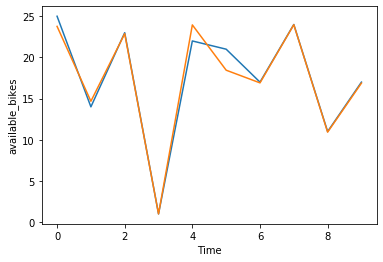


Station 80 	 available_bike_stands
MAE:  0.8104171632896305
MSE:  3.008620977353993
RMSE:  1.734537684039754
R2:  0.9616906309751226 



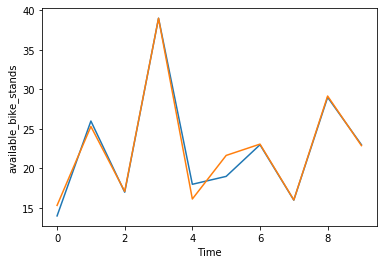


Station 41 	 available_bikes
MAE:  0.513969010727056
MSE:  0.9743315852205005
RMSE:  0.9870823598973393
R2:  0.9742092217504094 



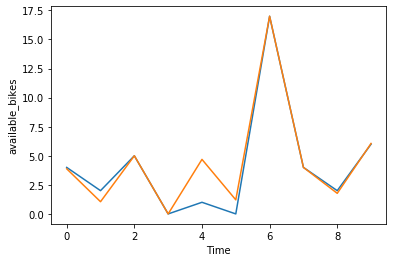


Station 41 	 available_bike_stands
MAE:  0.5144219308700835
MSE:  0.9755752085816447
RMSE:  0.9877121081477359
R2:  0.9742821857943962 



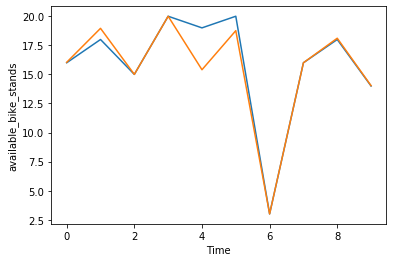


Station 3 	 available_bikes
MAE:  0.6995714285714284
MSE:  1.292532619047619
RMSE:  1.136896045840436
R2:  0.9408077748567835 



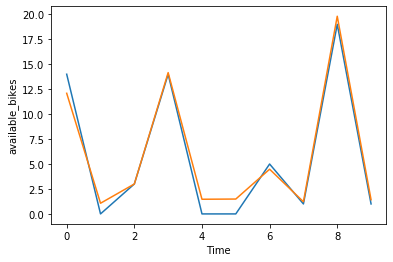


Station 3 	 available_bike_stands
MAE:  0.6980357142857143
MSE:  1.2678172619047618
RMSE:  1.1259739170623633
R2:  0.9418908403351574 



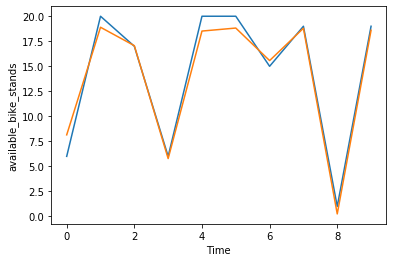


Station 40 	 available_bikes
MAE:  0.7995119047619047
MSE:  1.6194944047619044
RMSE:  1.272593574069076
R2:  0.9617704379395989 



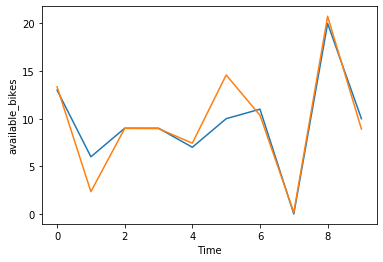


Station 40 	 available_bike_stands
MAE:  0.7920833333333333
MSE:  1.600864404761905
RMSE:  1.2652527039140857
R2:  0.9623659091893462 



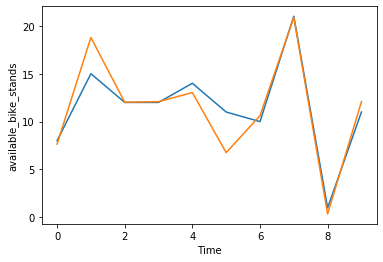


Station 29 	 available_bikes
MAE:  1.1193809523809524
MSE:  4.046315714285715
RMSE:  2.0115456033323516
R2:  0.9529985764813703 



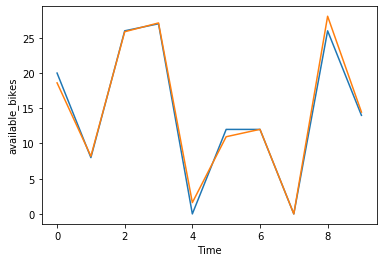


Station 29 	 available_bike_stands
MAE:  1.1055
MSE:  3.913962619047619
RMSE:  1.9783737308829237
R2:  0.9543729518469112 



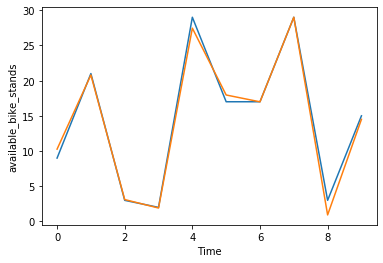


Station 103 	 available_bikes
MAE:  0.3585952380952381
MSE:  0.9044269047619047
RMSE:  0.9510136196511092
R2:  0.982041518368955 



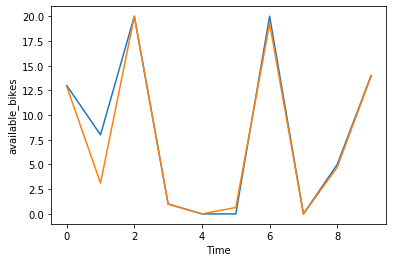


Station 103 	 available_bike_stands
MAE:  0.3627619047619048
MSE:  0.9164550000000001
RMSE:  0.9573165620629365
R2:  0.9818585264419463 



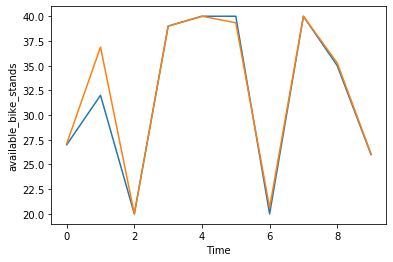


Station 28 	 available_bikes
MAE:  1.0852738095238095
MSE:  3.589419642857143
RMSE:  1.8945763755671459
R2:  0.9447923139538683 



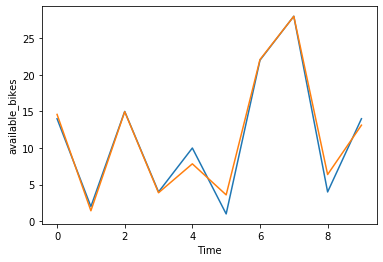


Station 28 	 available_bike_stands
MAE:  1.0933928571428573
MSE:  3.617905119047619
RMSE:  1.9020791568827042
R2:  0.9451815559971926 



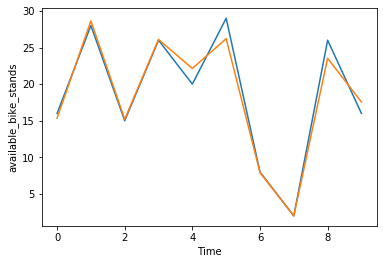


Station 39 	 available_bikes
MAE:  0.763095238095238
MSE:  1.527420476190476
RMSE:  1.2358885371223718
R2:  0.9193417429132854 



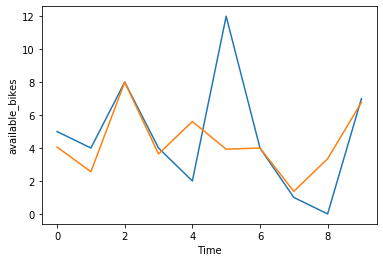


Station 39 	 available_bike_stands
MAE:  0.767357142857143
MSE:  1.5176471428571428
RMSE:  1.2319282214711793
R2:  0.9189141515974533 



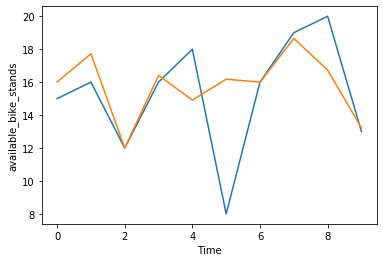


Station 83 	 available_bikes
MAE:  0.7916309523809524
MSE:  1.9958289285714286
RMSE:  1.4127380962412774
R2:  0.9832861128483618 



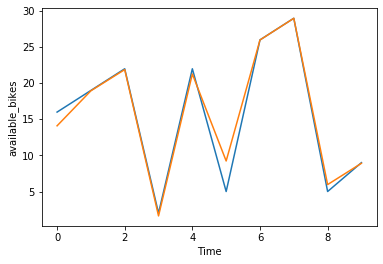


Station 83 	 available_bike_stands
MAE:  0.7856547619047619
MSE:  1.9875915476190473
RMSE:  1.4098196862077956
R2:  0.9834005355595288 



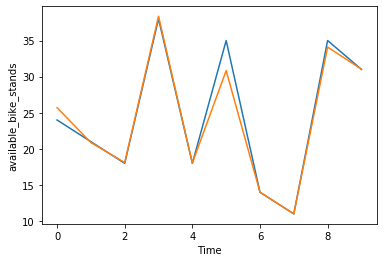


Station 92 	 available_bikes
MAE:  0.8835833333333334
MSE:  3.802174404761905
RMSE:  1.9499165122542823
R2:  0.9780471381931606 



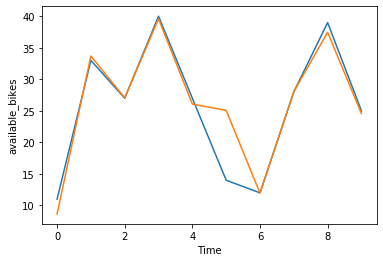


Station 92 	 available_bike_stands
MAE:  0.8930476190476191
MSE:  3.8619473809523814
RMSE:  1.9651838033508167
R2:  0.9776625025293721 



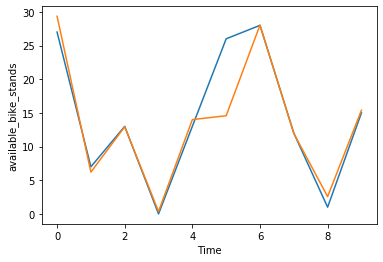


Station 21 	 available_bikes
MAE:  0.8271904761904761
MSE:  1.9851633333333334
RMSE:  1.4089582439992085
R2:  0.9754830387702579 



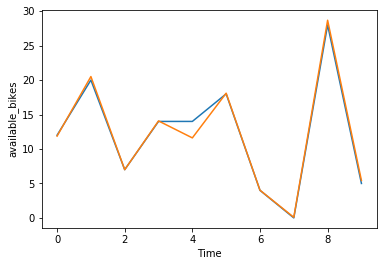


Station 21 	 available_bike_stands
MAE:  0.8303214285714287
MSE:  1.9934048809523812
RMSE:  1.4118799102446289
R2:  0.9758059611040828 



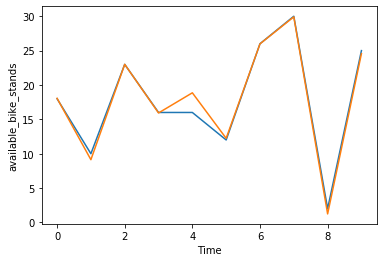


Station 88 	 available_bikes
MAE:  0.6234404761904763
MSE:  0.9541684523809525
RMSE:  0.9768154648555439
R2:  0.9878823286792414 



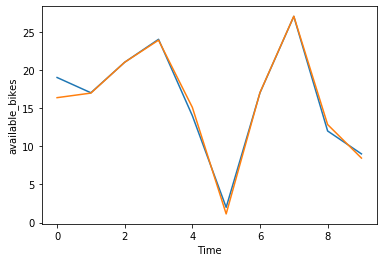


Station 88 	 available_bike_stands
MAE:  0.616702380952381
MSE:  0.9479529761904762
RMSE:  0.9736287671337963
R2:  0.9878976940259074 



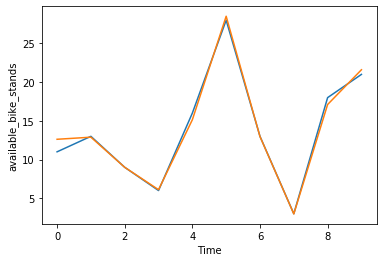

In [35]:
# Data processing pipeline 
targetCols = ['available_bikes','available_bike_stands']
# ***************************************************************************************************************


stations = dfML_enc['number'].unique()

with open('result_available_bikes.csv','a') as resultCSV:
        resultCSV.write("Station,MAE, MSE,RMSE,R2\n")
with open('result_available_bike_stands.csv','a') as resultCSV:
        resultCSV.write("Station,MAE, MSE,RMSE,R2\n")
        
for station in stations:
    dfML_station = dfML_enc.loc[dfML_enc['number'] == station] 
    dfML_enc_DA = dfML_station

    
    for targetCol in targetCols: 
    
        # Array of target variables
        target = np.array(dfML_enc_DA[targetCol])

        dfML_pipeline = dfML_enc_DA.drop(['available_bikes','available_bike_stands','number'], axis = 1)

        # Saving input feature names for later use
        feature_list = list(dfML_pipeline.columns)
        # Convert to numpy array
        features = np.array(dfML_pipeline)

        train_features, test_features, train_labels, test_labels = trainTestData(features, target)
        rfBikeModel = trainRandomForest(train_features, train_labels)

        # save the model
        filename = 'stn'+str(station)+"_"+targetCol+'.pkl'
        pickle.dump(rfBikeModel, open(filename, 'wb'))
        
        # load the model 
        rfBikeModel_loaded = pickle.load(open(filename, 'rb'))
        predictions = predictRandomForest(rfBikeModel_loaded,test_features)
        result(predictions,test_labels, targetCol,station)
        # show_Importance(rfBikeModel_loaded,features)        